In [234]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [235]:
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,6)
sns.set()
plt.style.use('ggplot')

pd.set_option('display.max_columns', None)

from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

In [338]:
train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [339]:
train.shape

(1460, 81)

In [340]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [341]:
train.isnull().sum().sort_values(ascending=False)[train.isnull().sum() > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [342]:
#Around 90% of data is missing in this columns, the only right decision is to drop them
train.drop(columns={'PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu'},inplace=True)
test.drop(columns={'PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu'},inplace=True)

In [343]:
train.drop('Id',axis=1,inplace=True)

In [242]:
test.isnull().sum().sort_values(ascending=False)[test.isnull().sum() > 0]

LotFrontage     227
GarageYrBlt      78
GarageFinish     78
GarageQual       78
GarageCond       78
GarageType       76
BsmtCond         45
BsmtQual         44
BsmtExposure     44
BsmtFinType1     42
BsmtFinType2     42
MasVnrArea       15
MSZoning          4
Functional        2
BsmtHalfBath      2
Utilities         2
BsmtFullBath      2
Exterior2nd       1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
KitchenQual       1
Exterior1st       1
GarageCars        1
GarageArea        1
SaleType          1
dtype: int64

In [344]:
cat_cols = train.select_dtypes(include='object').columns
cat_imputer = SimpleImputer(strategy='most_frequent')

train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])
test[cat_cols]  = cat_imputer.transform(test[cat_cols])

In [345]:
num_cols = train.select_dtypes(include='number').columns.drop('SalePrice')
num_imputer = SimpleImputer(strategy='median')

train[num_cols] = num_imputer.fit_transform(train[num_cols])
test[num_cols]  = num_imputer.transform(test[num_cols])

In [245]:
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

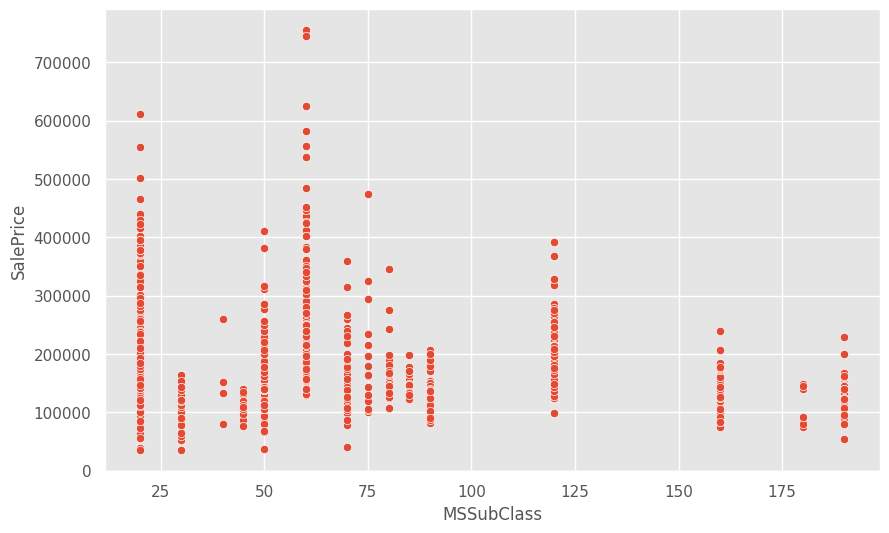

In [246]:
sns.scatterplot(data=train,x='MSSubClass',y='SalePrice')
plt.show()

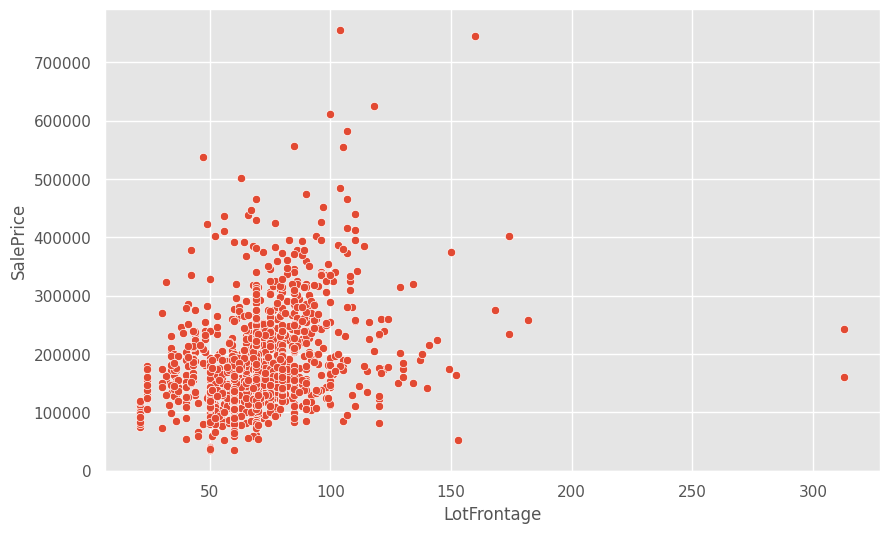

In [247]:
sns.scatterplot(data=train,x='LotFrontage',y='SalePrice')
plt.show()

In [346]:
percentile25 = train['LotFrontage'].quantile(0.25)
percentile75 = train['LotFrontage'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR

train = train[train['LotFrontage'] < upper_limit]

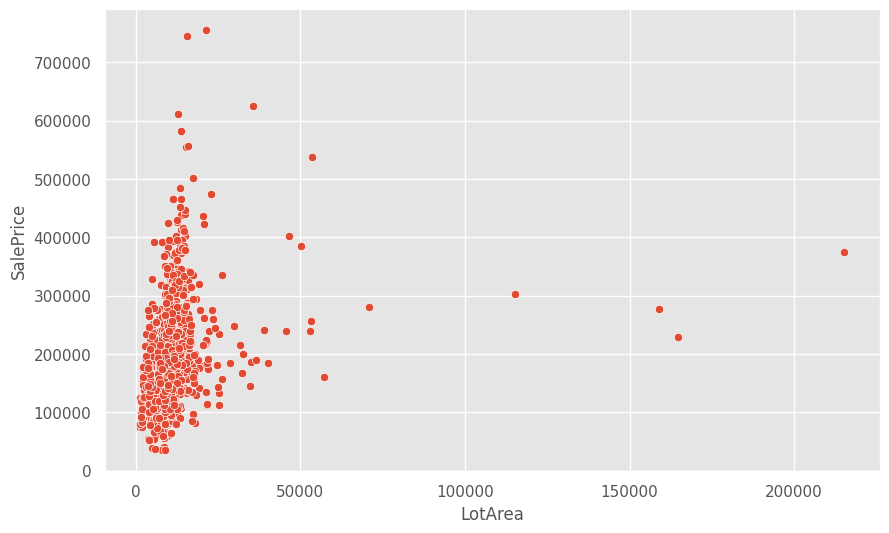

In [249]:
sns.scatterplot(data=train,x='LotArea',y='SalePrice')
plt.show()

In [347]:
percentile25 = train['LotArea'].quantile(0.25)
percentile75 = train['LotArea'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR

train = train[train['LotArea'] < upper_limit]

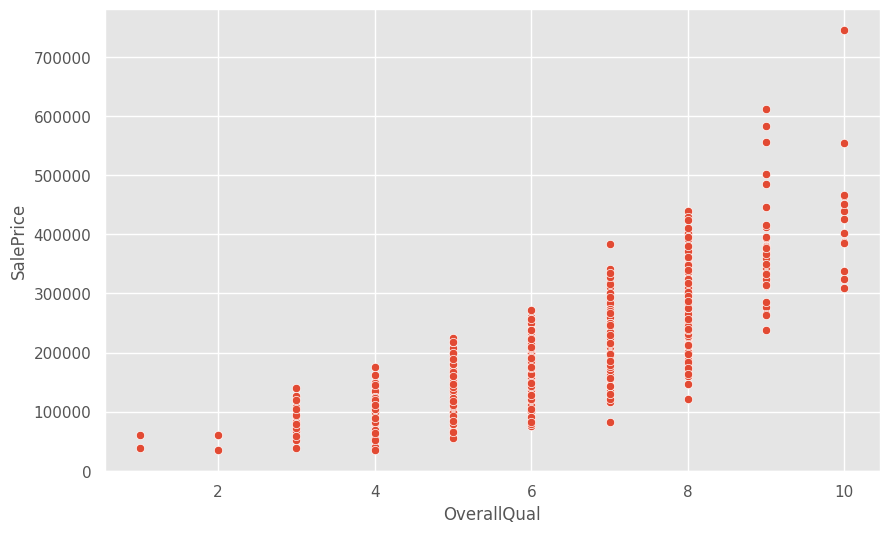

In [251]:
sns.scatterplot(data=train,x='OverallQual',y='SalePrice')
plt.show()

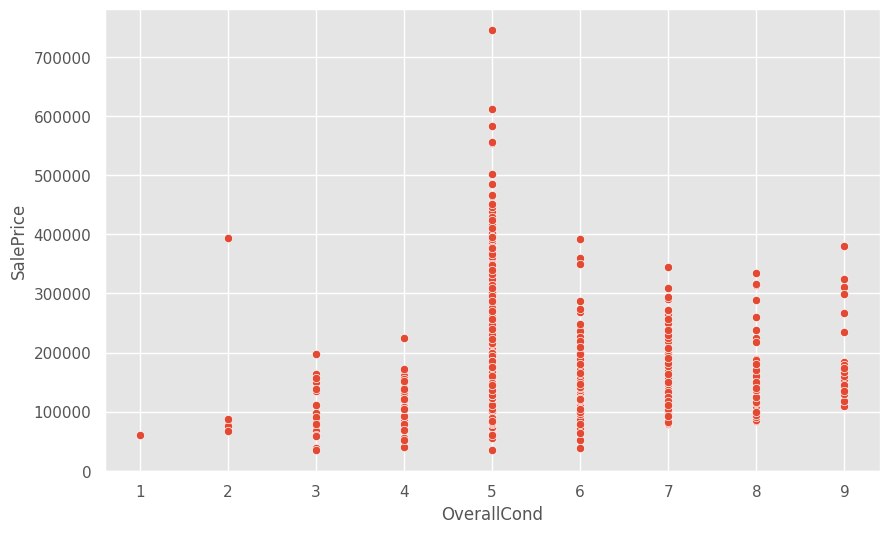

In [252]:
sns.scatterplot(data=train,x='OverallCond',y='SalePrice')
plt.show()

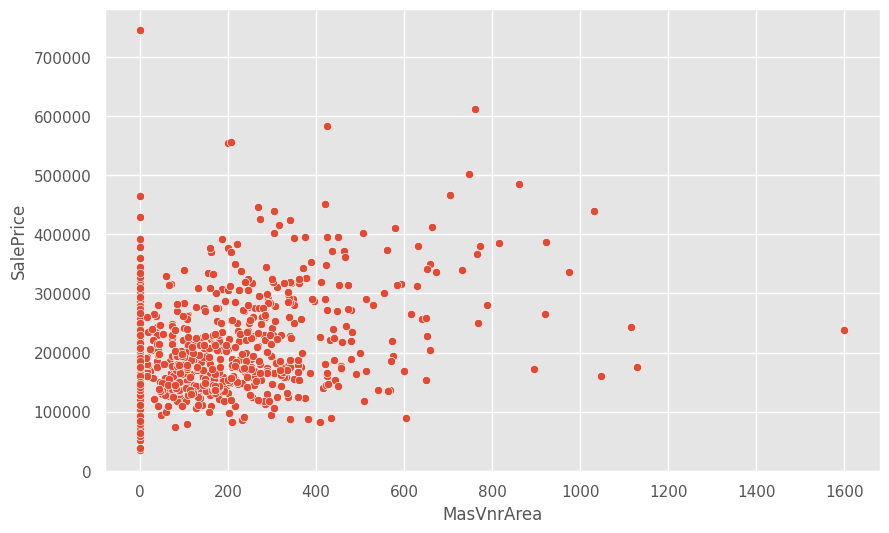

In [253]:
sns.scatterplot(data=train,x='MasVnrArea',y='SalePrice')
plt.show()

In [348]:
train = train[train['MasVnrArea'] <1200 ]

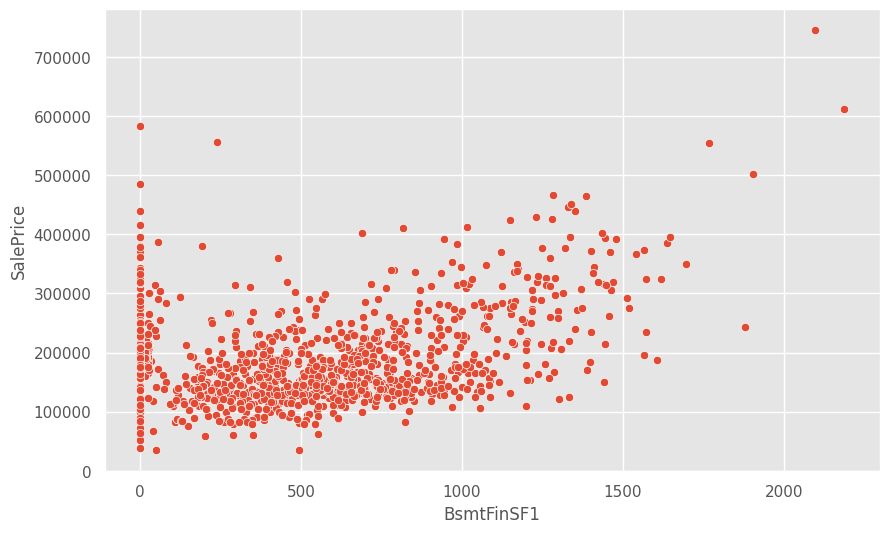

In [255]:
sns.scatterplot(data=train,x='BsmtFinSF1',y='SalePrice')
plt.show()

In [350]:
percentile25 = train['BsmtFinSF1'].quantile(0.25)
percentile75 = train['BsmtFinSF1'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR
train = train[train['BsmtFinSF1'] < upper_limit]

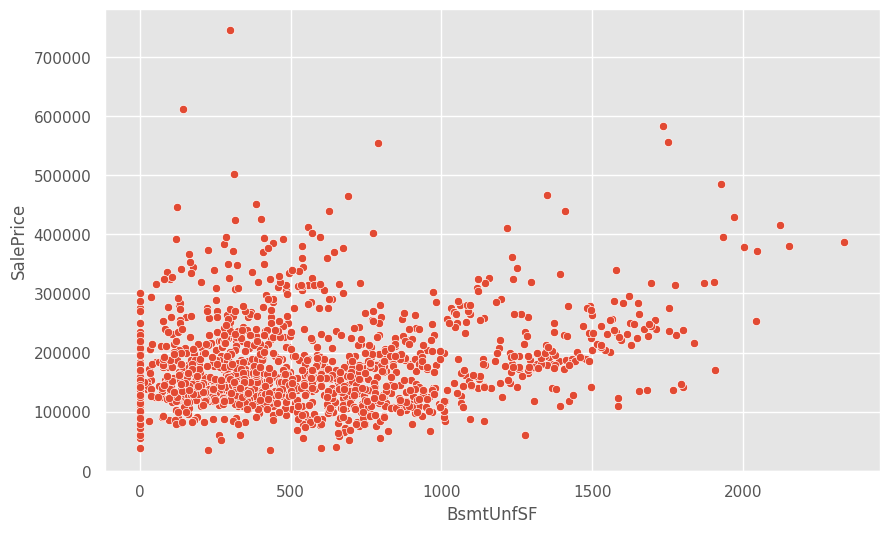

In [256]:
sns.scatterplot(data=train,x='BsmtUnfSF',y='SalePrice')
plt.show()

In [352]:
percentile25 = train['BsmtUnfSF'].quantile(0.25)
percentile75 = train['BsmtUnfSF'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR
train = train[train['BsmtUnfSF'] < upper_limit]

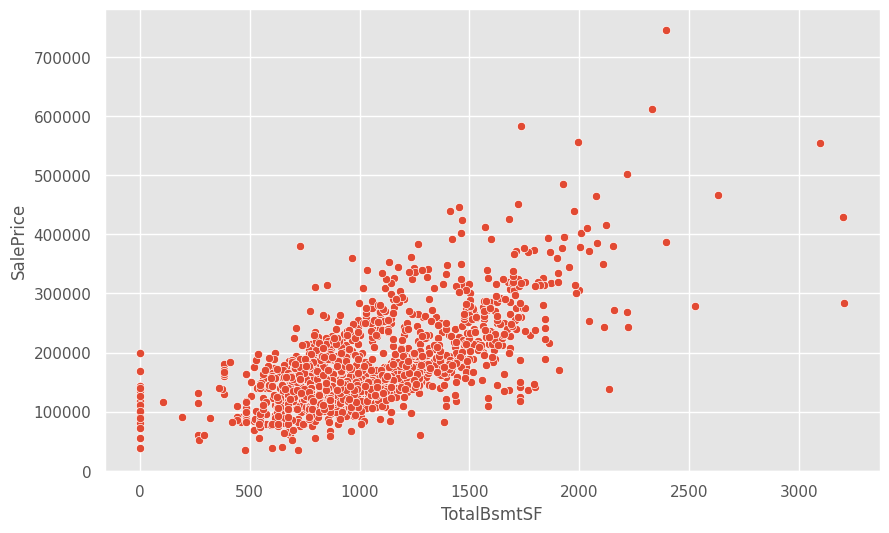

In [257]:
sns.scatterplot(data=train,x='TotalBsmtSF',y='SalePrice')
plt.show()

In [354]:
percentile25 = train['TotalBsmtSF'].quantile(0.25)
percentile75 = train['TotalBsmtSF'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR
#print(upper_limit)
train = train[train['TotalBsmtSF'] < upper_limit]

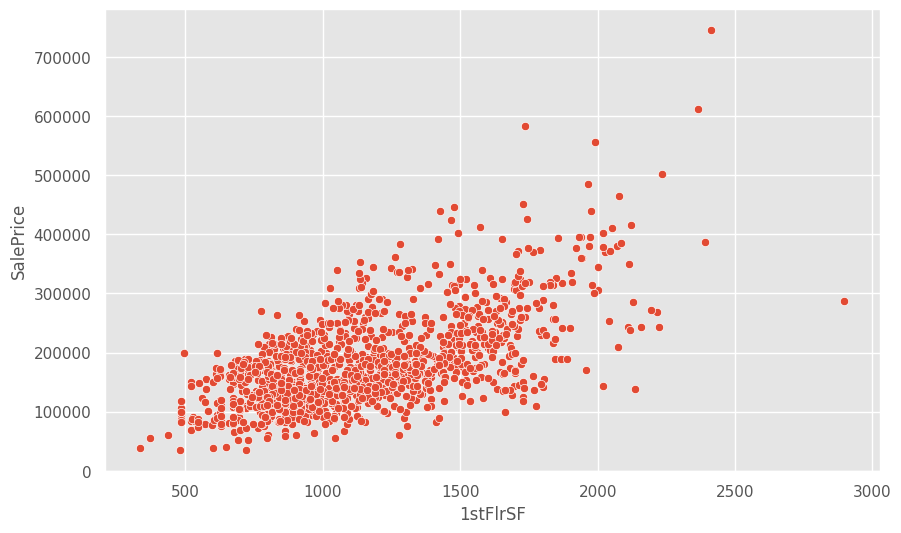

In [259]:
sns.scatterplot(data=train,x='1stFlrSF',y='SalePrice')
plt.show()

In [356]:
percentile25 = train['1stFlrSF'].quantile(0.25)
percentile75 = train['1stFlrSF'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR
train = train[train['1stFlrSF'] < upper_limit]

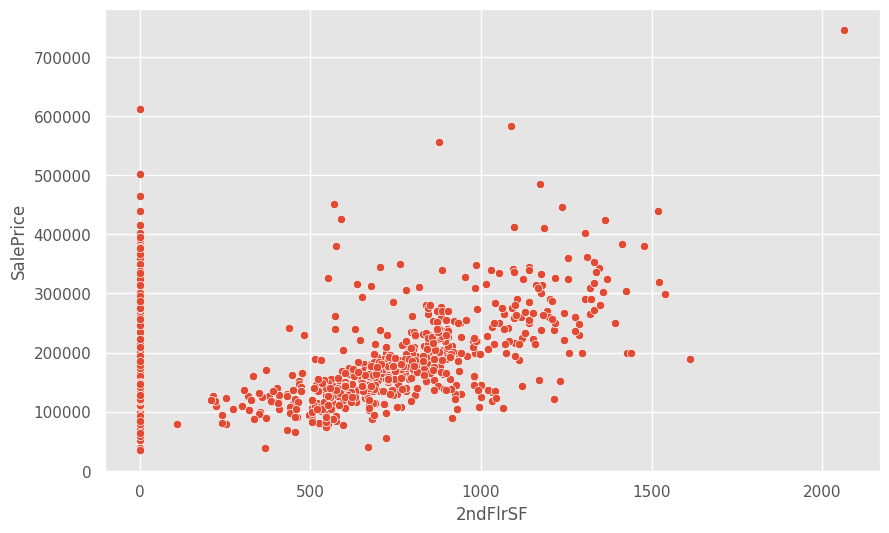

In [261]:
sns.scatterplot(data=train,x='2ndFlrSF',y='SalePrice')
plt.show()

In [358]:
percentile25 = train['2ndFlrSF'].quantile(0.25)
percentile75 = train['2ndFlrSF'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR
train = train[train['2ndFlrSF'] < upper_limit]

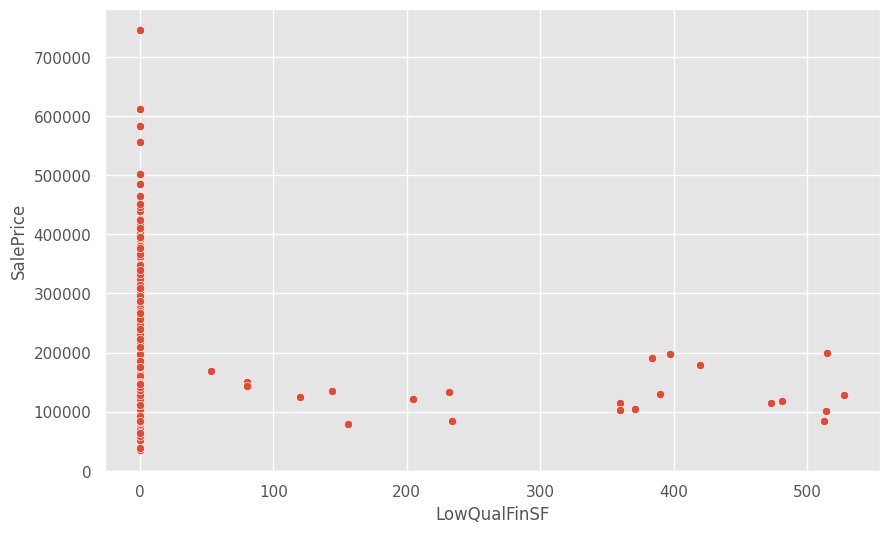

In [262]:
sns.scatterplot(data=train,x='LowQualFinSF',y='SalePrice')
plt.show()

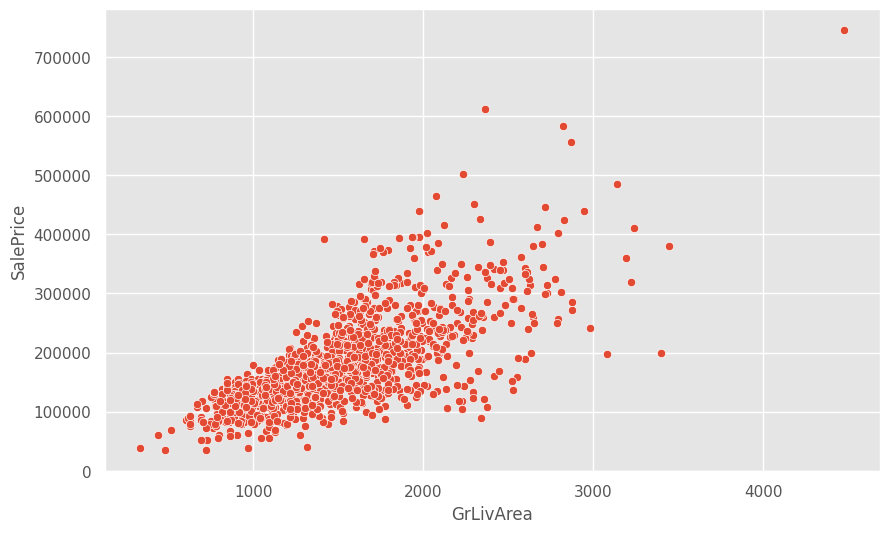

In [263]:
sns.scatterplot(data=train,x='GrLivArea',y='SalePrice')
plt.show()

In [362]:
percentile25 = train['GrLivArea'].quantile(0.25)
percentile75 = train['GrLivArea'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR
train = train[train['GrLivArea'] < upper_limit]

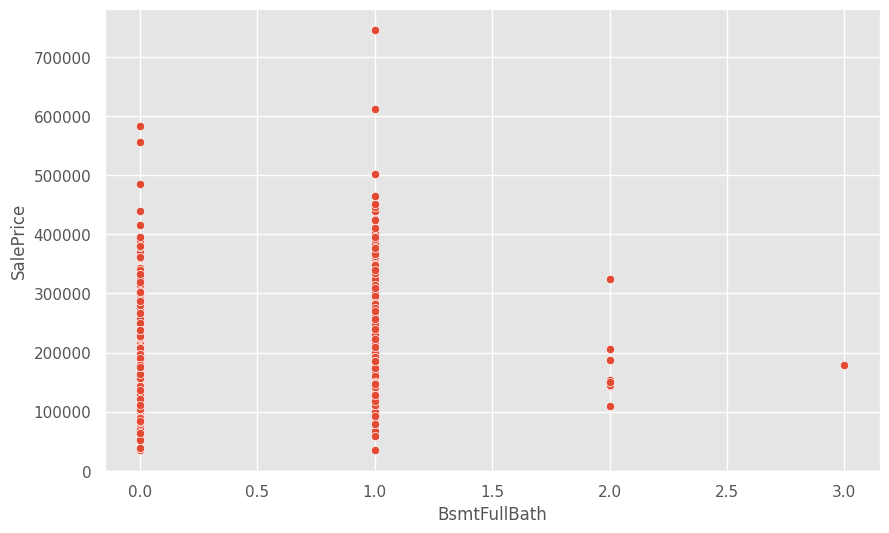

In [264]:
sns.scatterplot(data=train,x='BsmtFullBath',y='SalePrice')
plt.show()

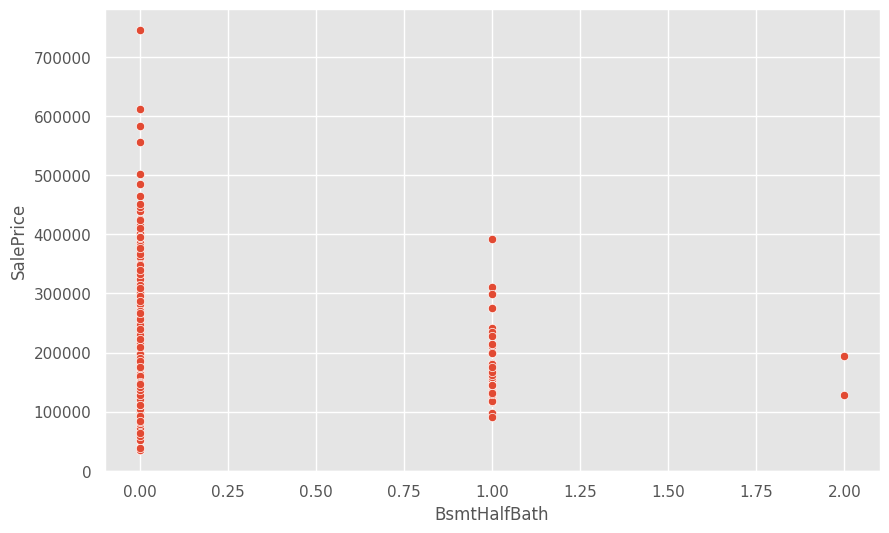

In [265]:
sns.scatterplot(data=train,x='BsmtHalfBath',y='SalePrice')
plt.show()

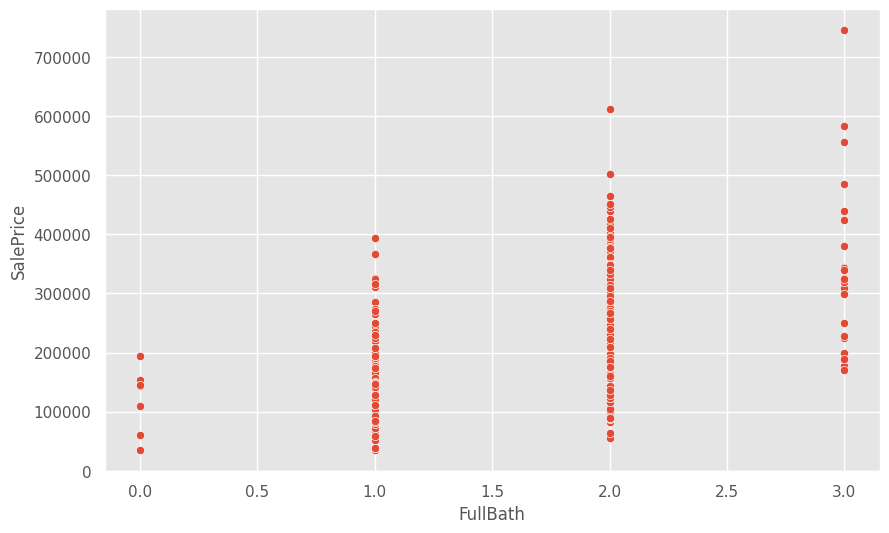

In [266]:
sns.scatterplot(data=train,x='FullBath',y='SalePrice')
plt.show()

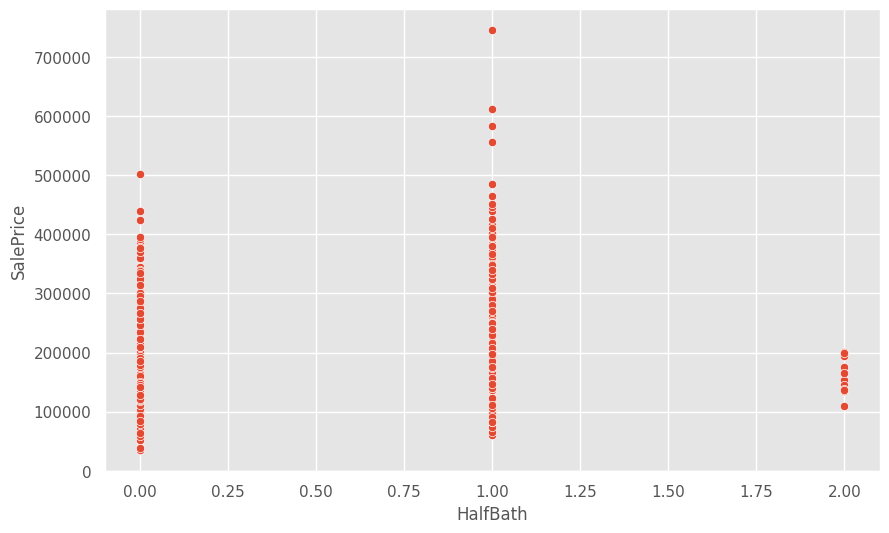

In [267]:
sns.scatterplot(data=train,x='HalfBath',y='SalePrice')
plt.show()

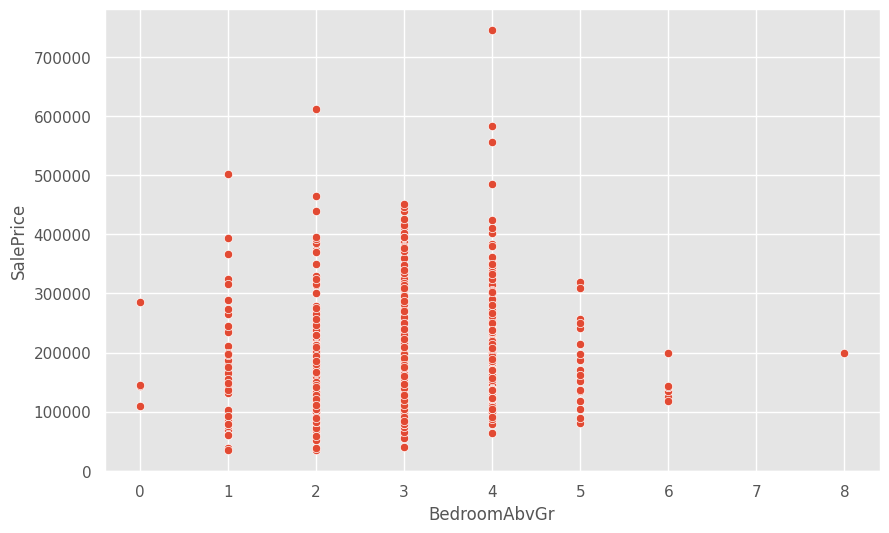

In [268]:
sns.scatterplot(data=train,x='BedroomAbvGr',y='SalePrice')
plt.show()

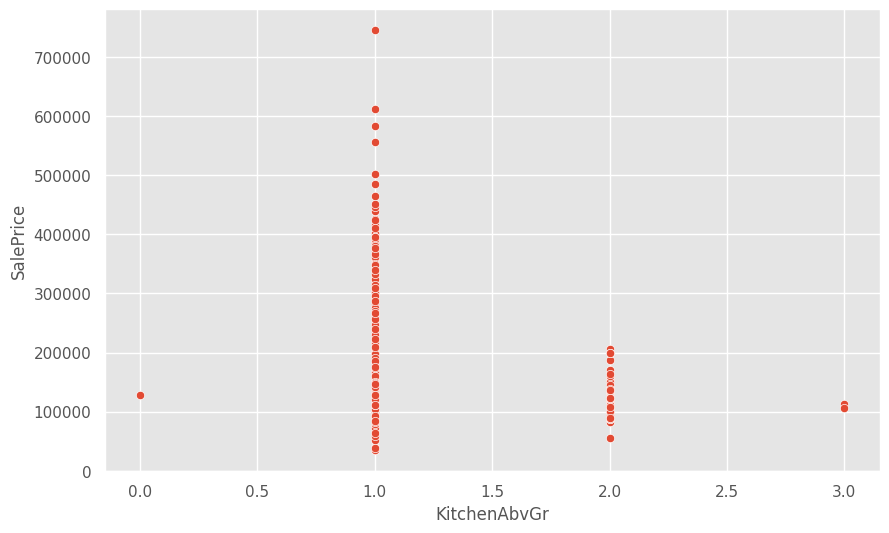

In [269]:
sns.scatterplot(data=train,x='KitchenAbvGr',y='SalePrice')
plt.show()

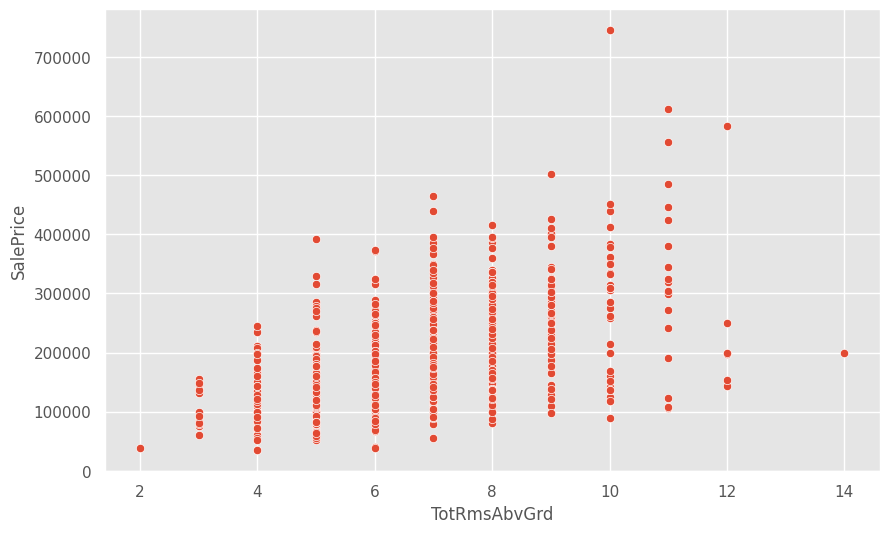

In [270]:
sns.scatterplot(data=train,x='TotRmsAbvGrd',y='SalePrice')
plt.show()

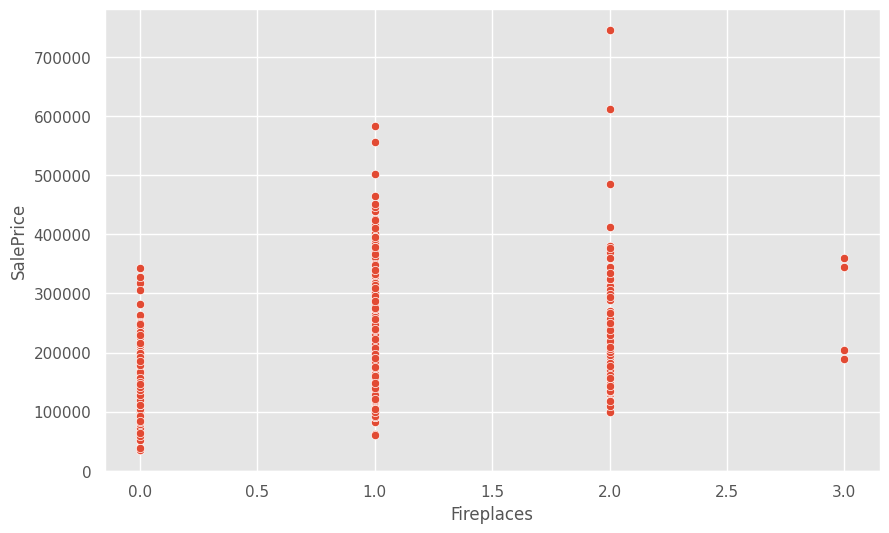

In [271]:
sns.scatterplot(data=train,x='Fireplaces',y='SalePrice')
plt.show()

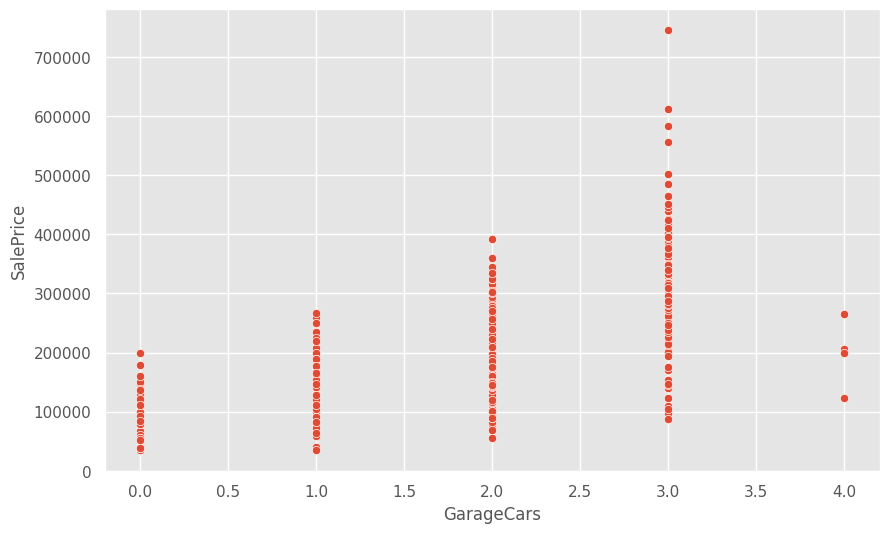

In [272]:
sns.scatterplot(data=train,x='GarageCars',y='SalePrice')
plt.show()

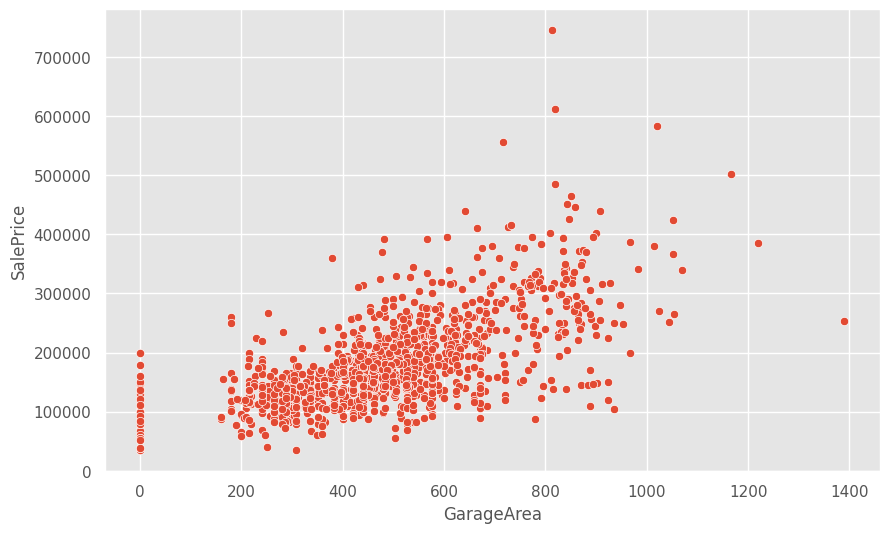

In [273]:
sns.scatterplot(data=train,x='GarageArea',y='SalePrice')
plt.show()

In [364]:
percentile25 = train['GarageArea'].quantile(0.25)
percentile75 = train['GarageArea'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR
train = train[train['GarageArea'] < upper_limit]

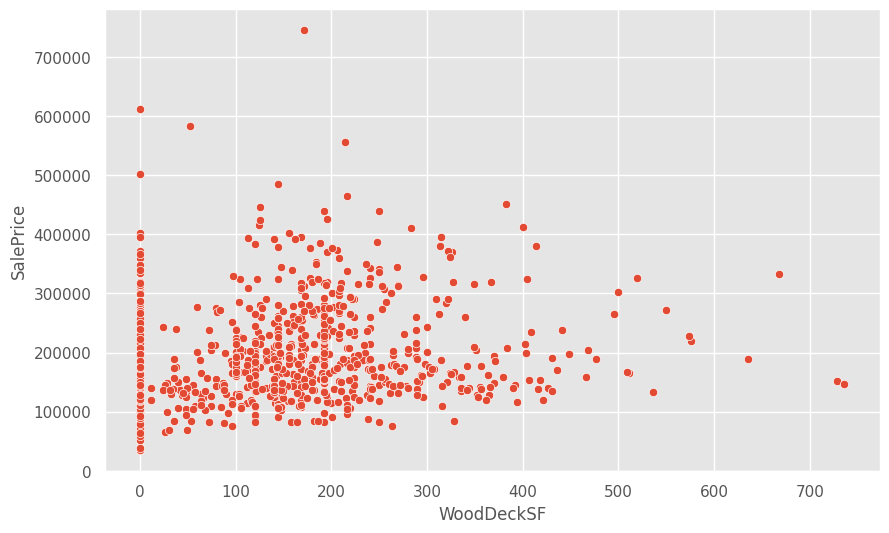

In [274]:
sns.scatterplot(data=train,x='WoodDeckSF',y='SalePrice')
plt.show()

In [366]:
percentile25 = train['WoodDeckSF'].quantile(0.25)
percentile75 = train['WoodDeckSF'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR
train = train[train['WoodDeckSF'] < upper_limit]

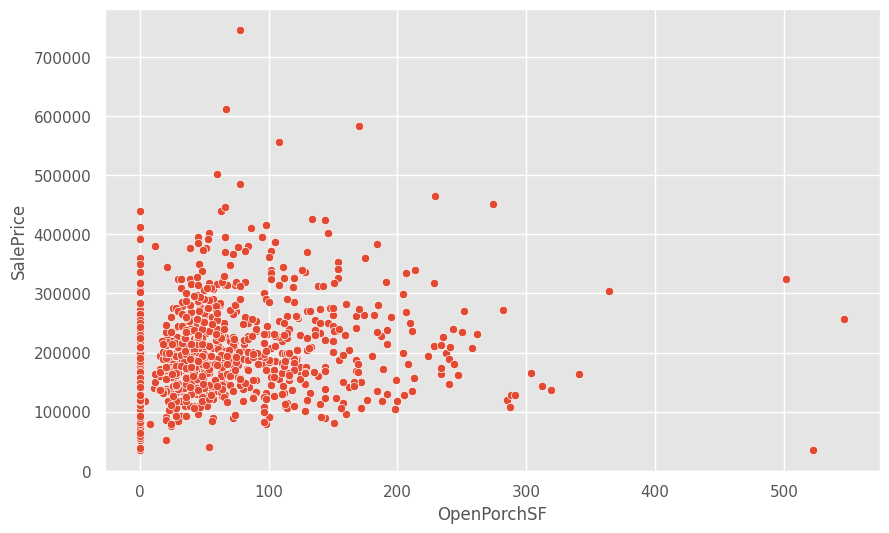

In [276]:
sns.scatterplot(data=train,x='OpenPorchSF',y='SalePrice')
plt.show()

In [368]:
train = train[train['OpenPorchSF'] < 300]

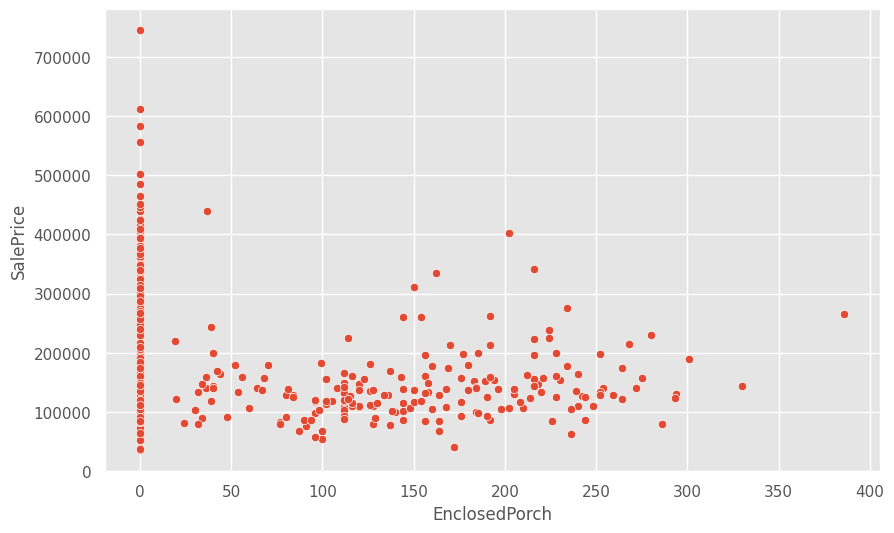

In [278]:
sns.scatterplot(data=train,x='EnclosedPorch',y='SalePrice')
plt.show()

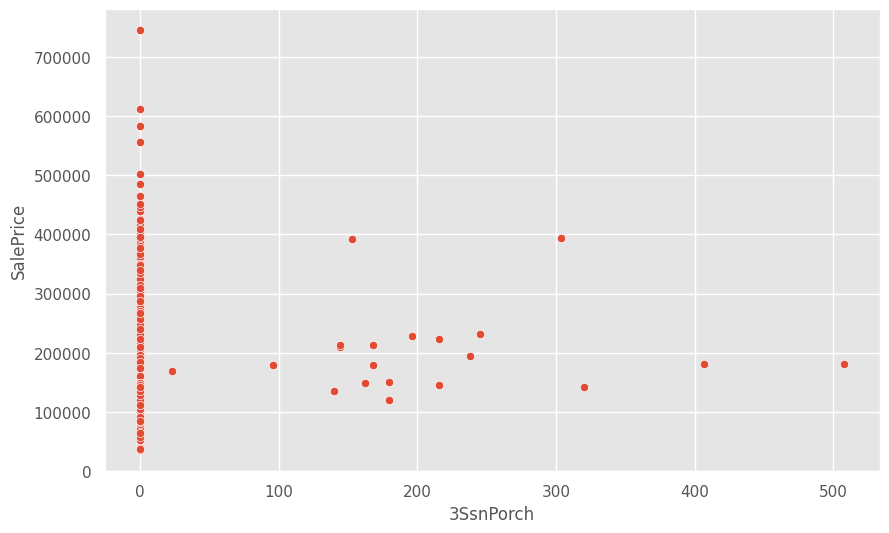

In [279]:
sns.scatterplot(data=train,x='3SsnPorch',y='SalePrice')
plt.show()

In [369]:
train.drop('3SsnPorch',axis=1,inplace=True)
test.drop('3SsnPorch',axis=1,inplace=True)

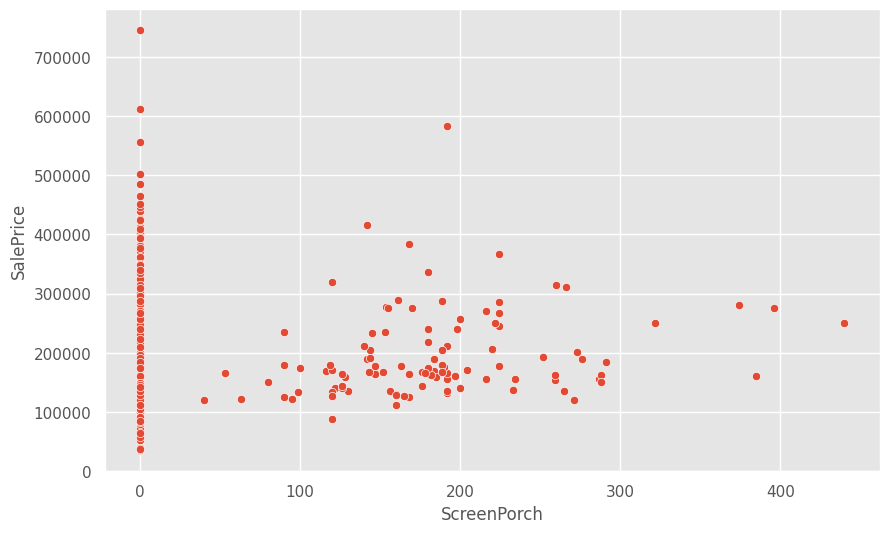

In [280]:
sns.scatterplot(data=train,x='ScreenPorch',y='SalePrice')
plt.show()

In [370]:
train.drop('ScreenPorch',axis=1,inplace=True)
test.drop('ScreenPorch',axis=1,inplace=True)

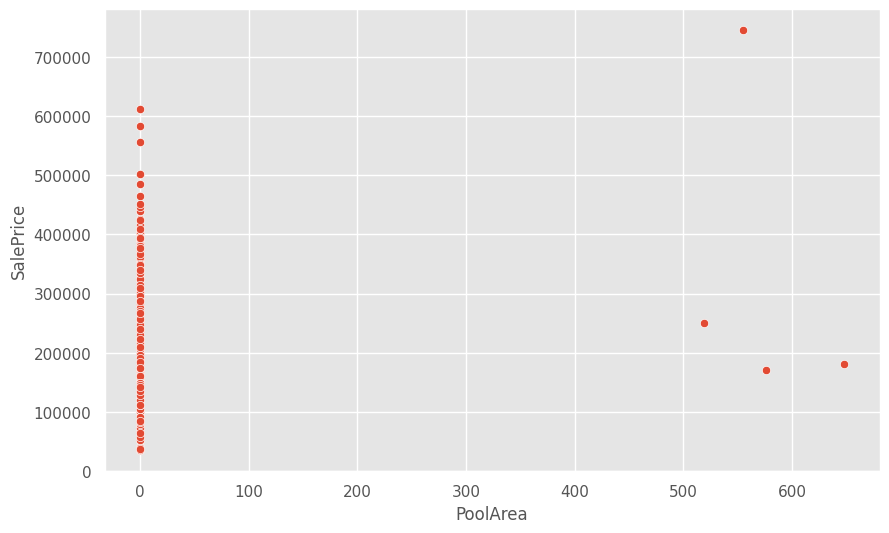

In [281]:
sns.scatterplot(data=train,x='PoolArea',y='SalePrice')
plt.show()

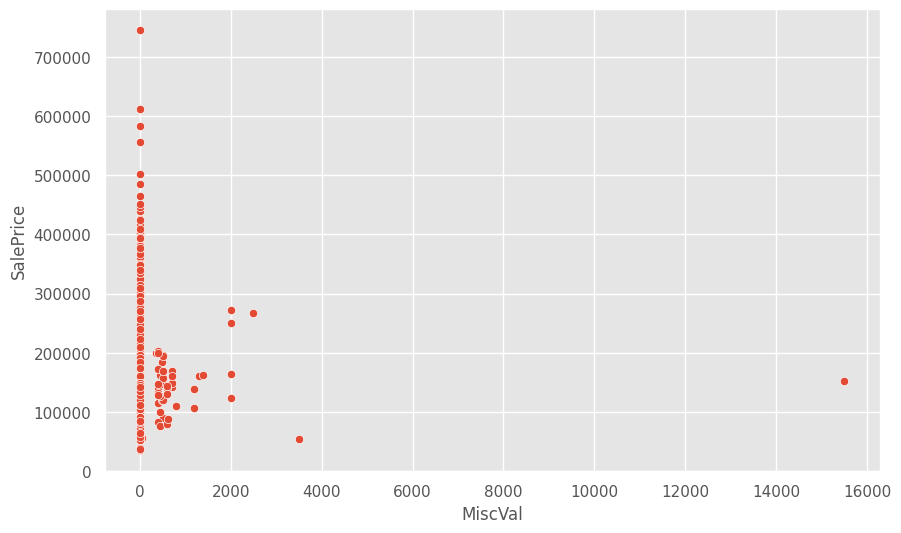

In [282]:
sns.scatterplot(data=train,x='MiscVal',y='SalePrice')
plt.show()

In [371]:
train = train[train['MiscVal'] < 15000]

In [372]:
train.reset_index(drop='True',inplace=True)
train.shape

(1226, 72)

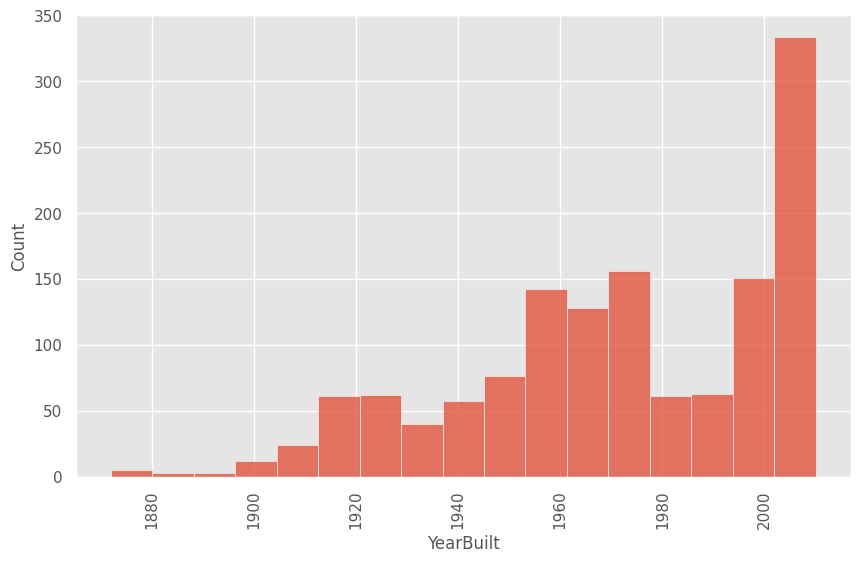

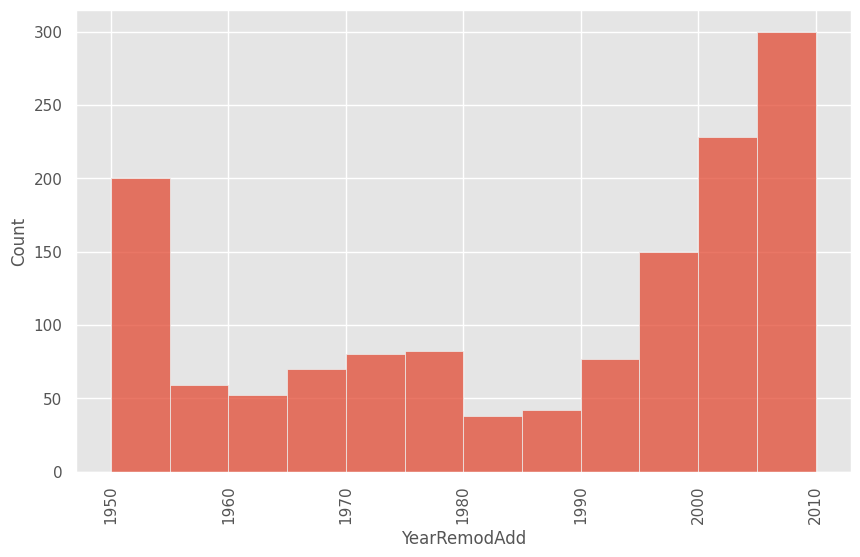

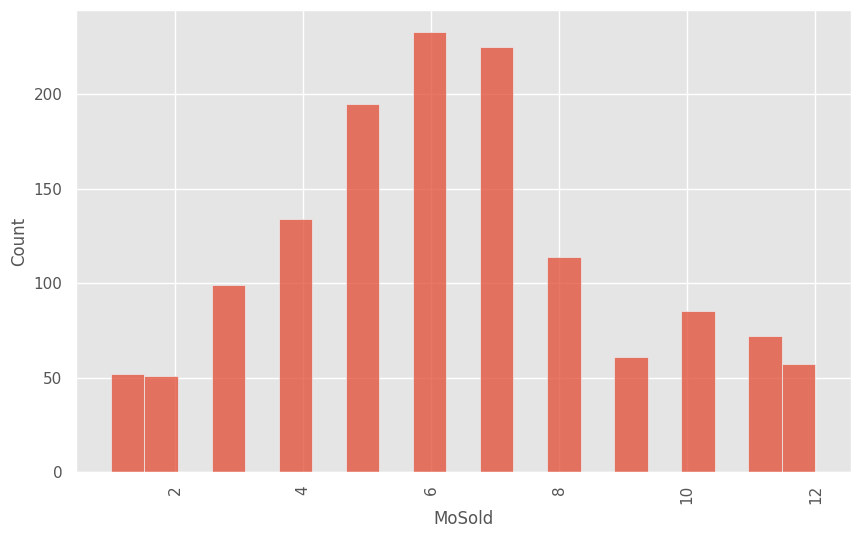

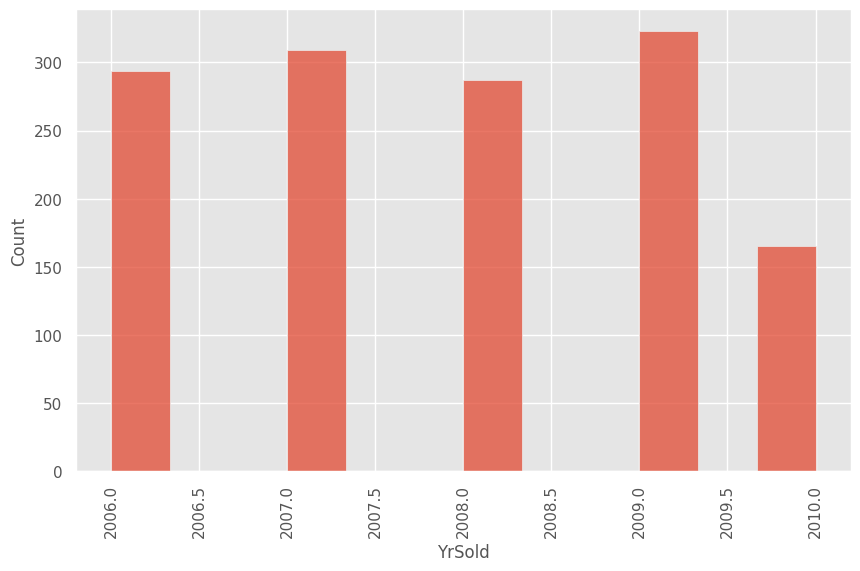

In [285]:
date_cols=['YearBuilt','YearRemodAdd','MoSold','YrSold']
for col in date_cols:
    sns.histplot(data=train,x=col)
    plt.xticks(rotation=90)
    plt.show()

In [286]:
cat_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [374]:
for col in cat_cols:
    print(f"{col}")
    print(train[col].value_counts(normalize=True)*100)
    print(40*"-")

MSZoning
MSZoning
RL         76.672104
RM         16.721044
FV          4.893964
RH          1.060359
C (all)     0.652529
Name: proportion, dtype: float64
----------------------------------------
Street
Street
Pave    99.836868
Grvl     0.163132
Name: proportion, dtype: float64
----------------------------------------
LotShape
LotShape
Reg    66.394780
IR1    31.566069
IR2     1.794454
IR3     0.244698
Name: proportion, dtype: float64
----------------------------------------
LandContour
LandContour
Lvl    91.761827
Bnk     4.078303
HLS     2.854812
Low     1.305057
Name: proportion, dtype: float64
----------------------------------------
Utilities
Utilities
AllPub    99.918434
NoSeWa     0.081566
Name: proportion, dtype: float64
----------------------------------------
LotConfig
LotConfig
Inside     74.143556
Corner     16.802610
CulDSac     5.464927
FR2         3.344209
FR3         0.244698
Name: proportion, dtype: float64
----------------------------------------
LandSlope
LandSlope


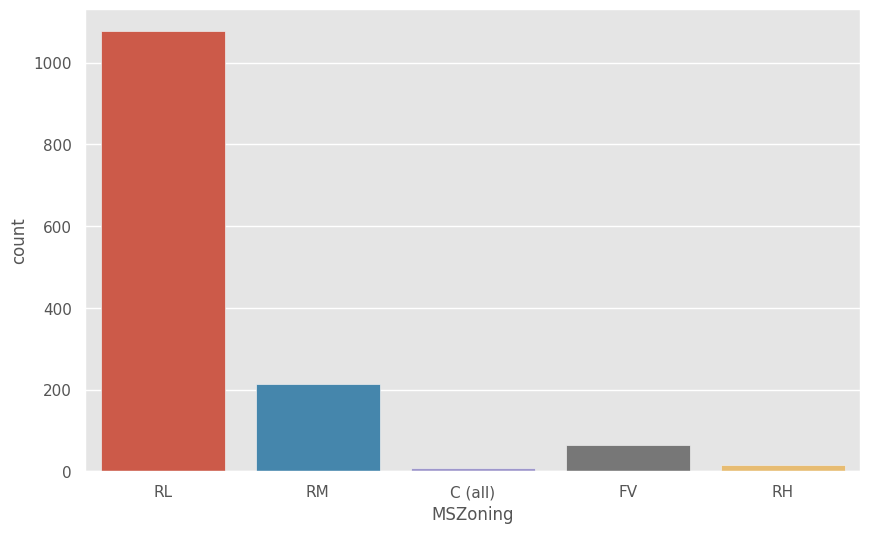

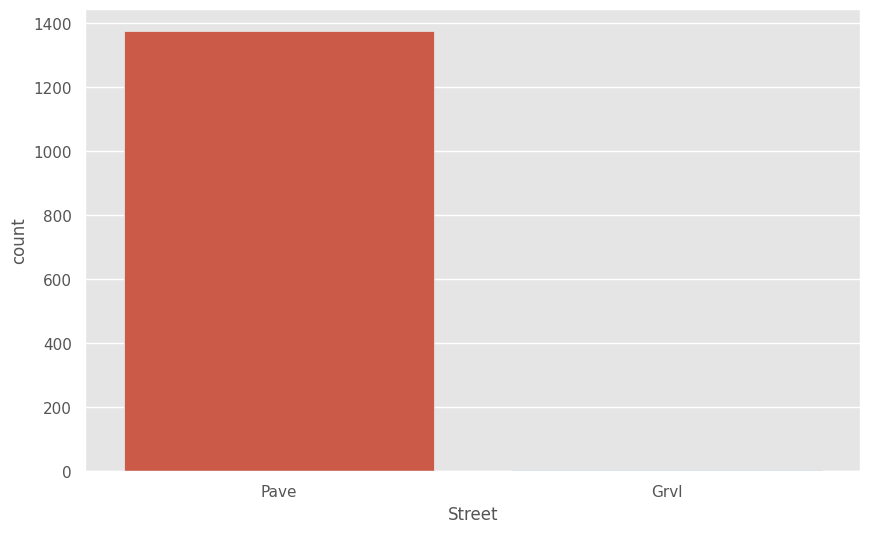

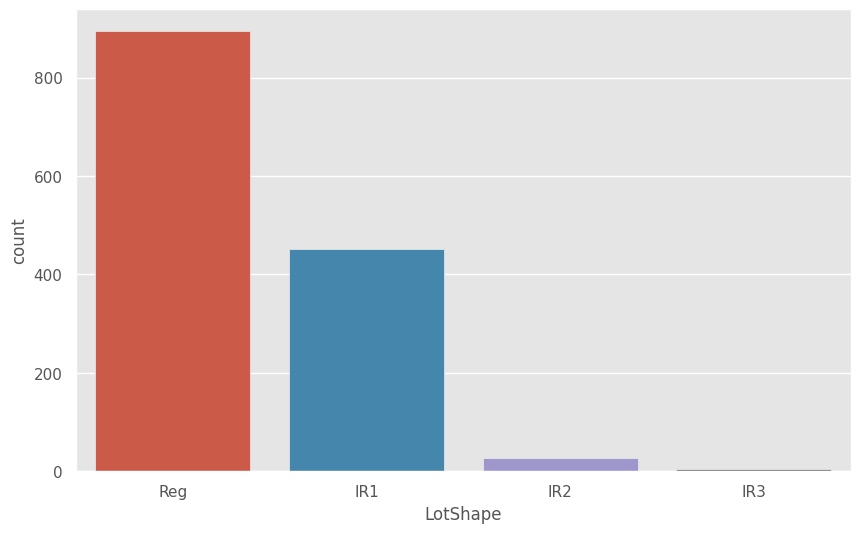

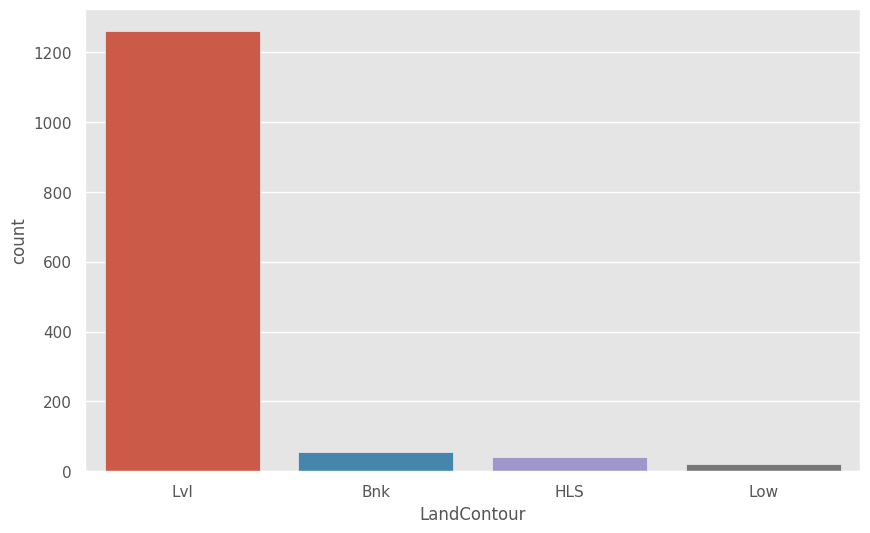

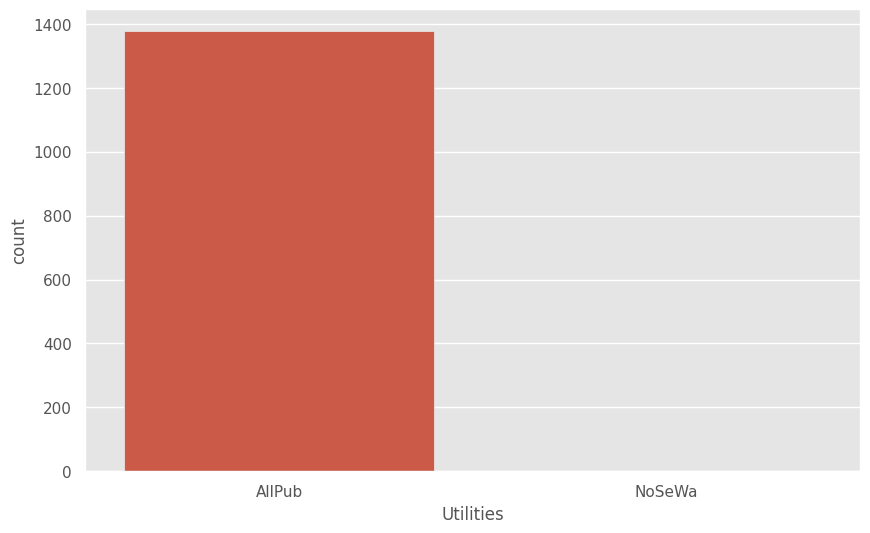

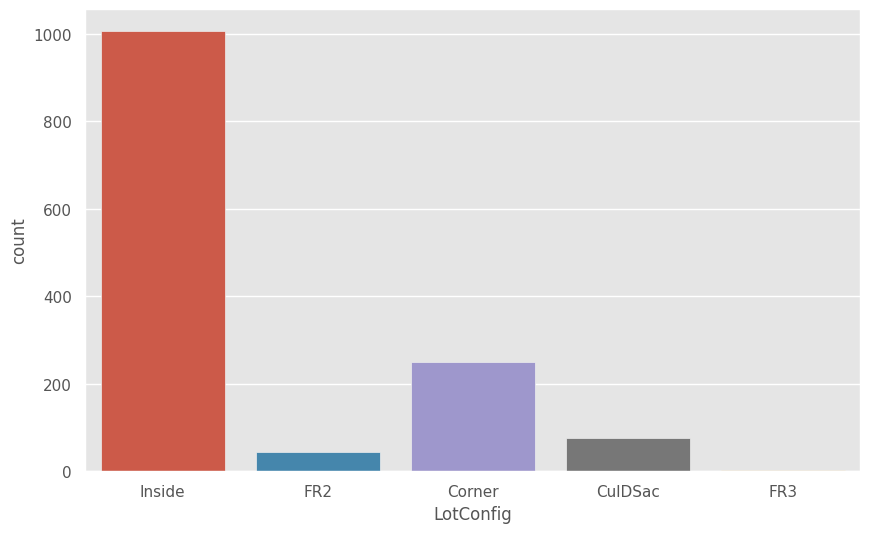

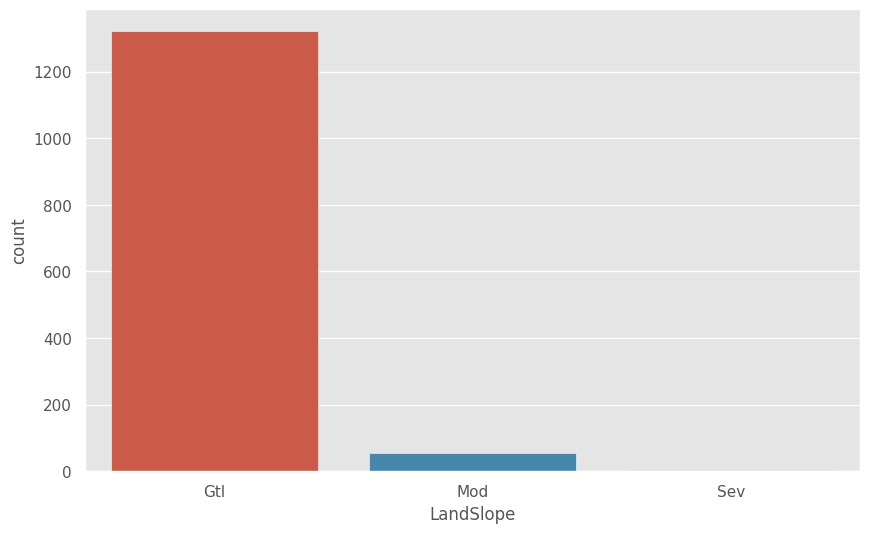

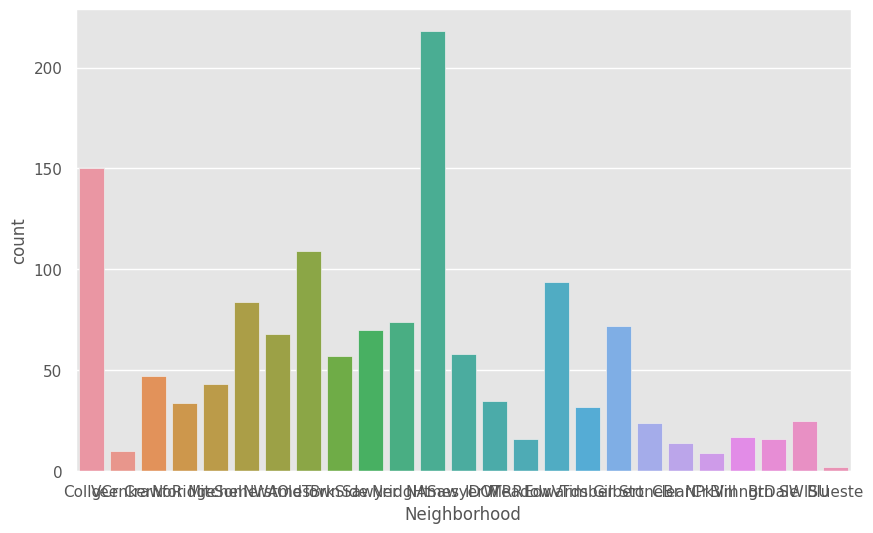

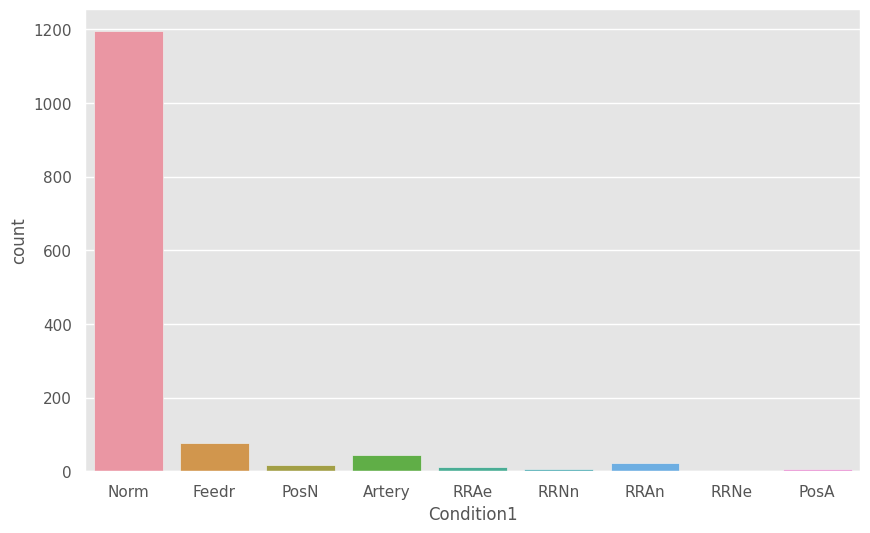

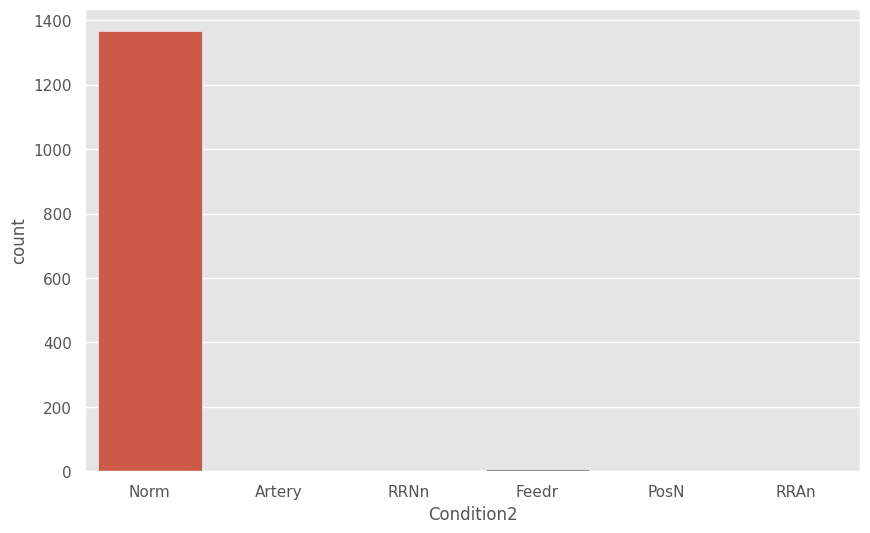

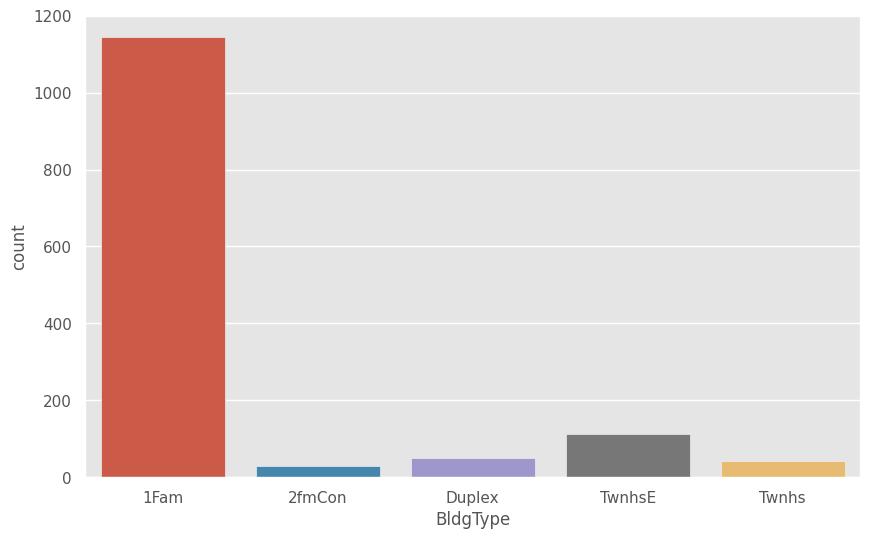

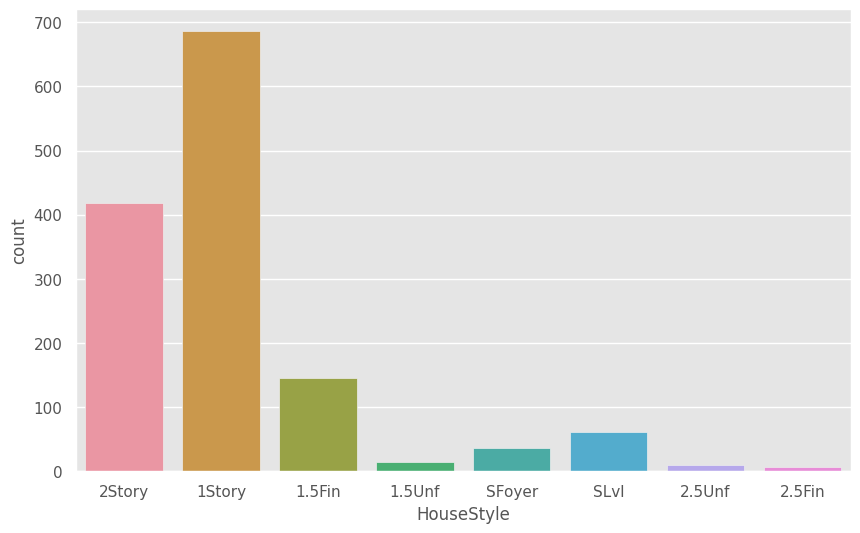

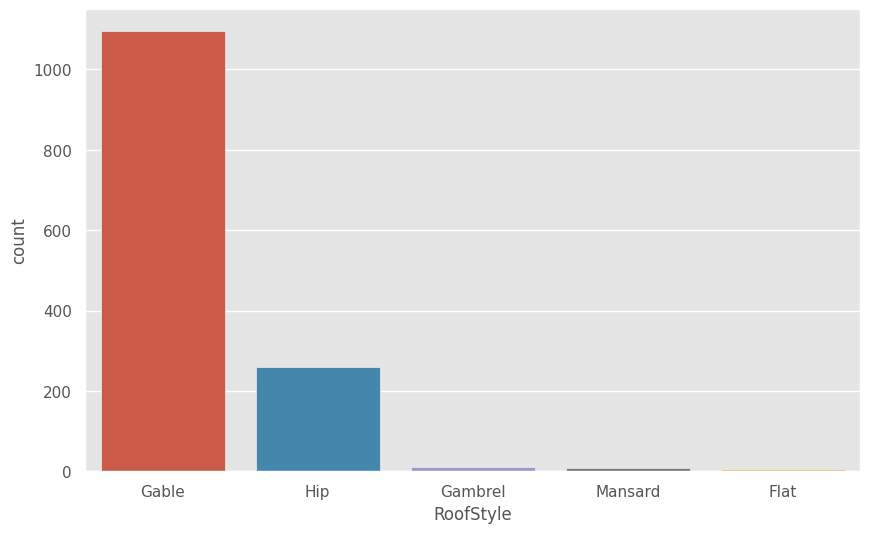

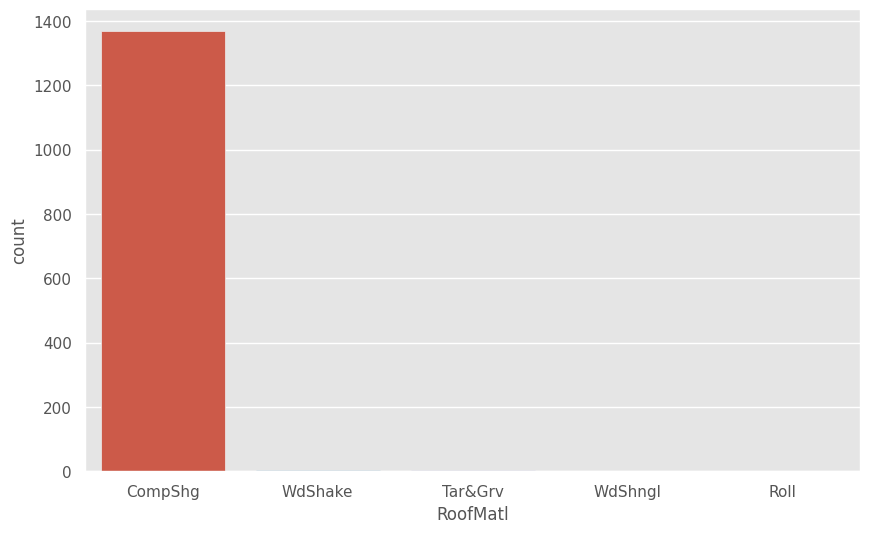

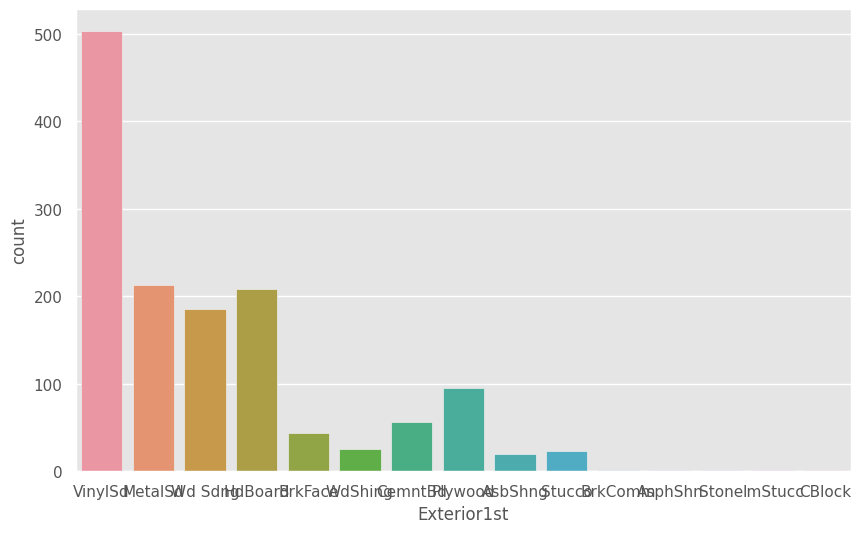

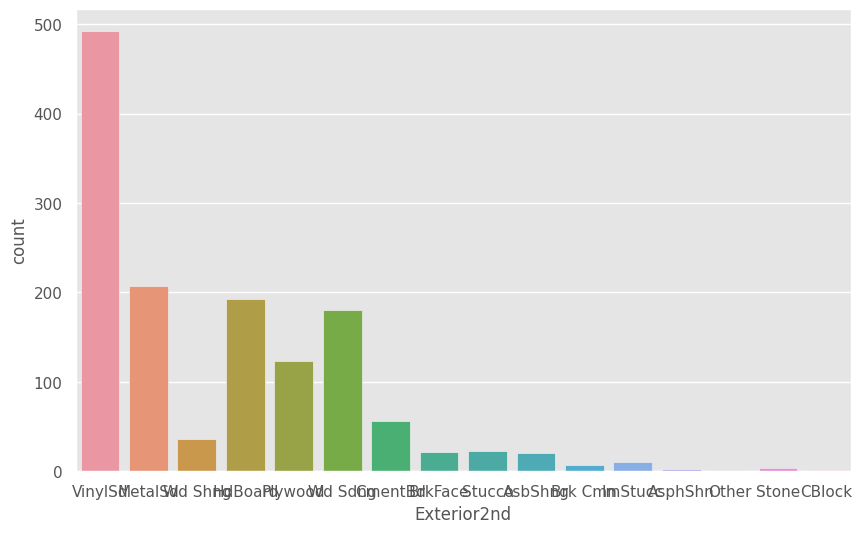

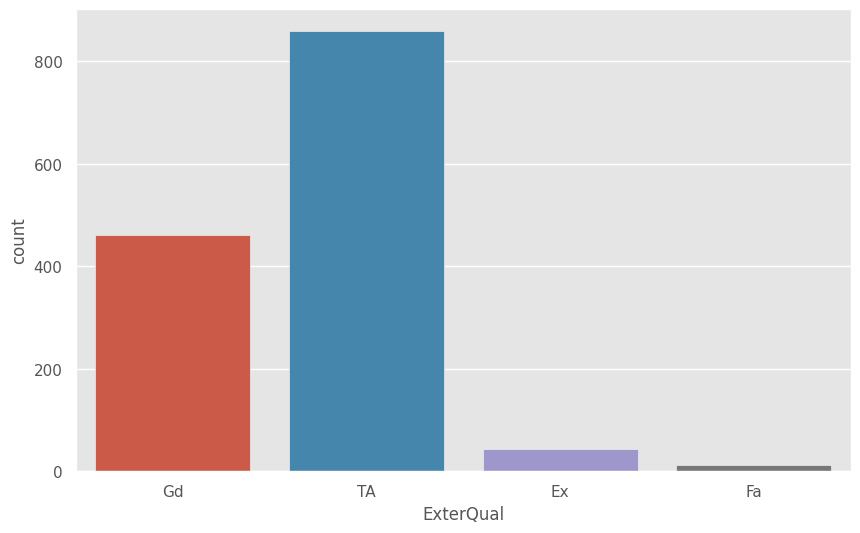

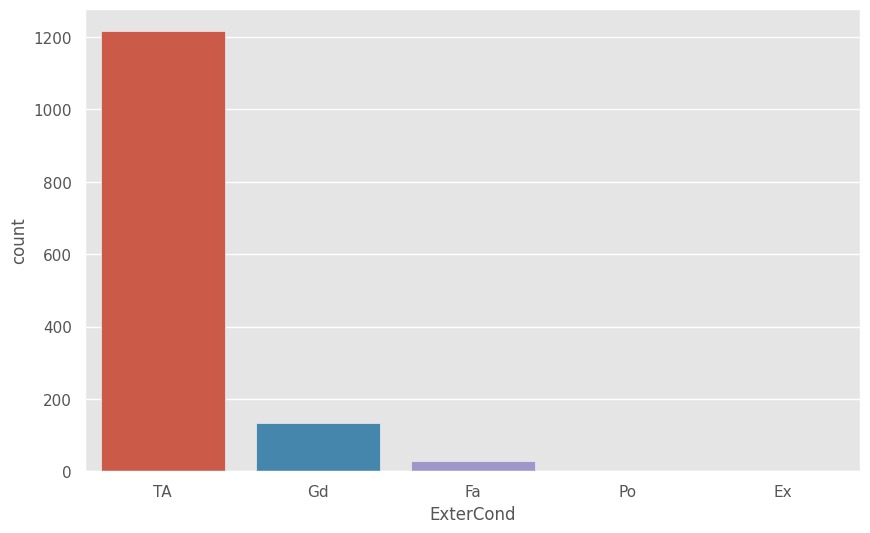

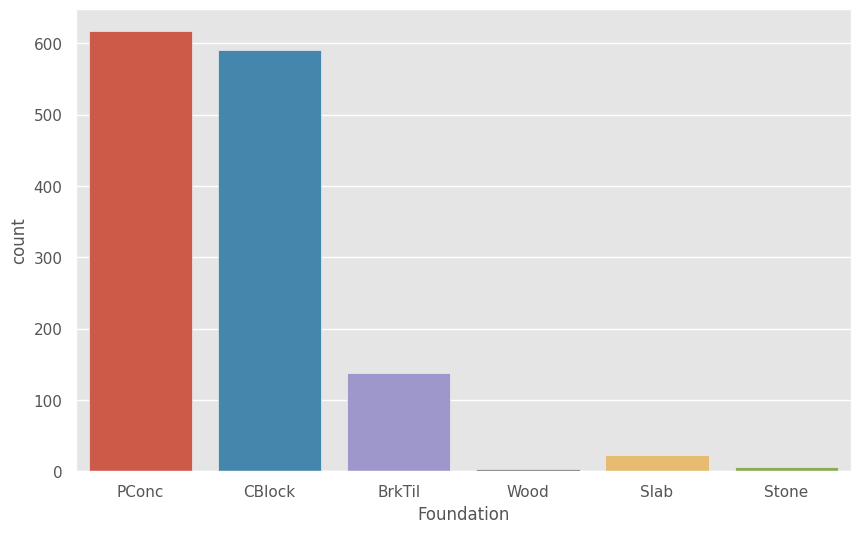

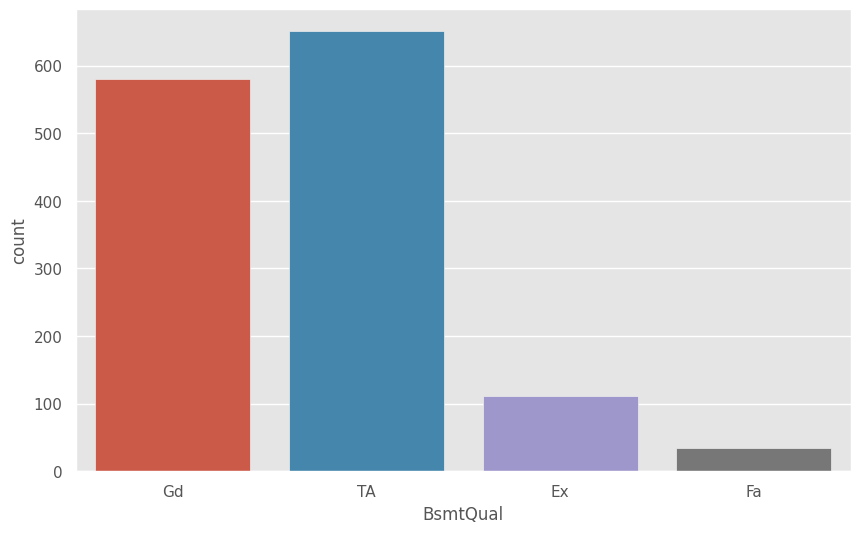

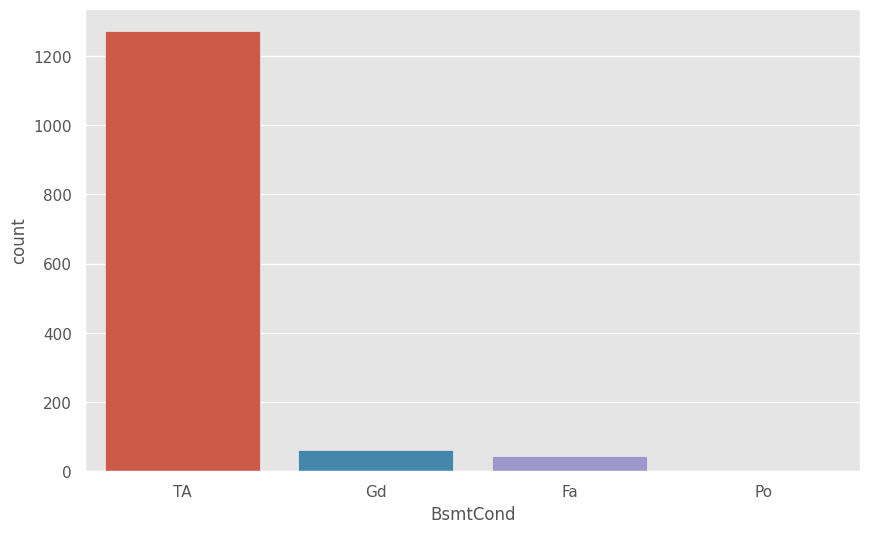

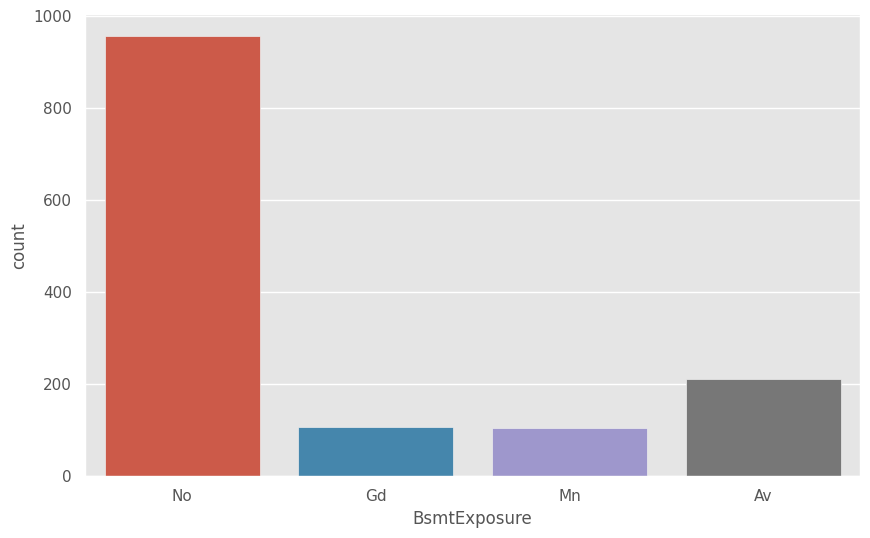

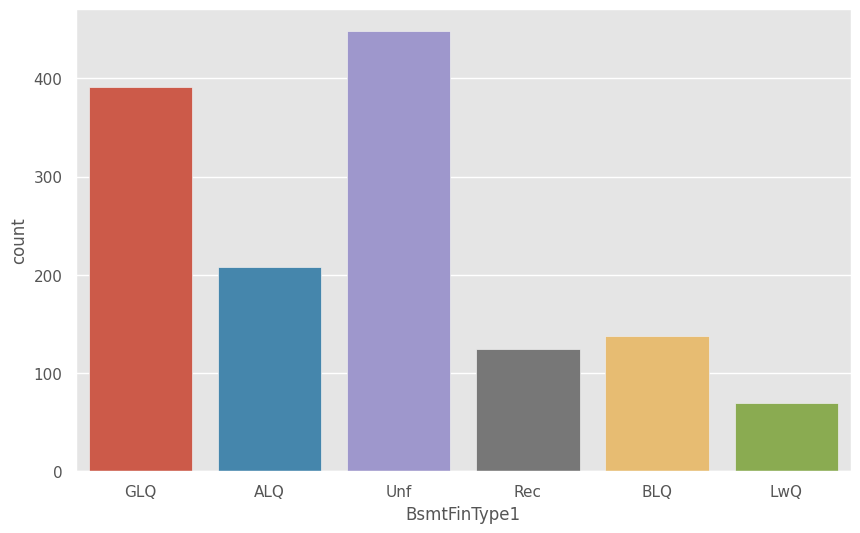

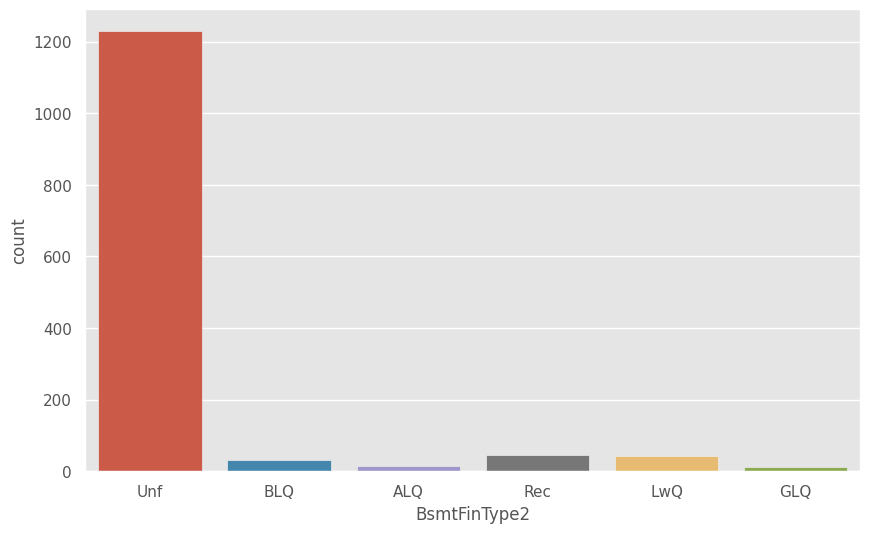

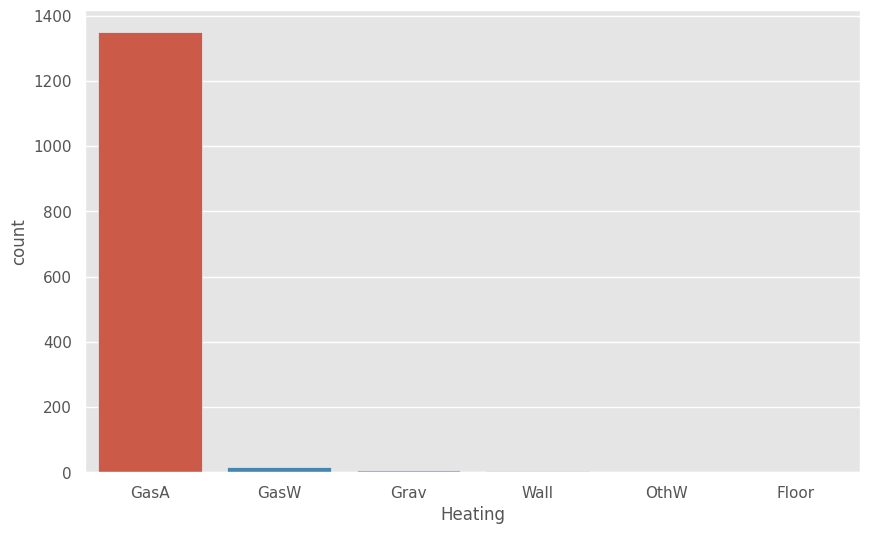

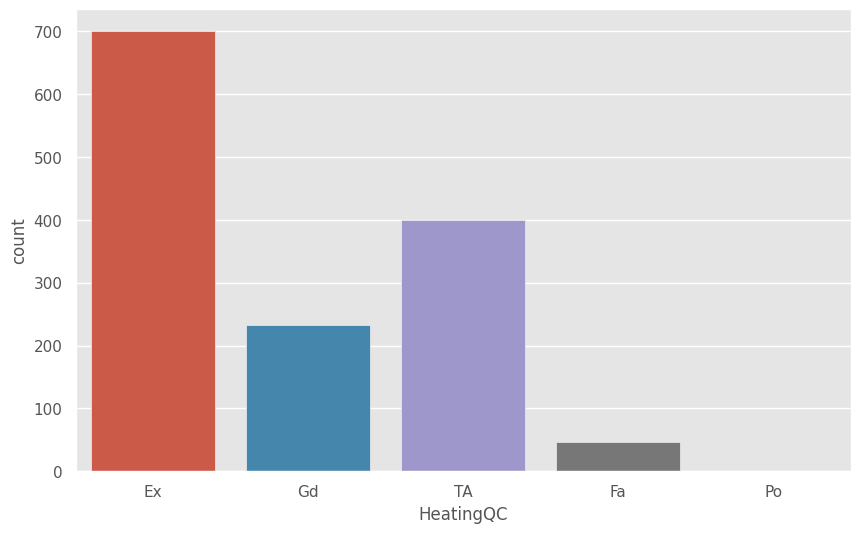

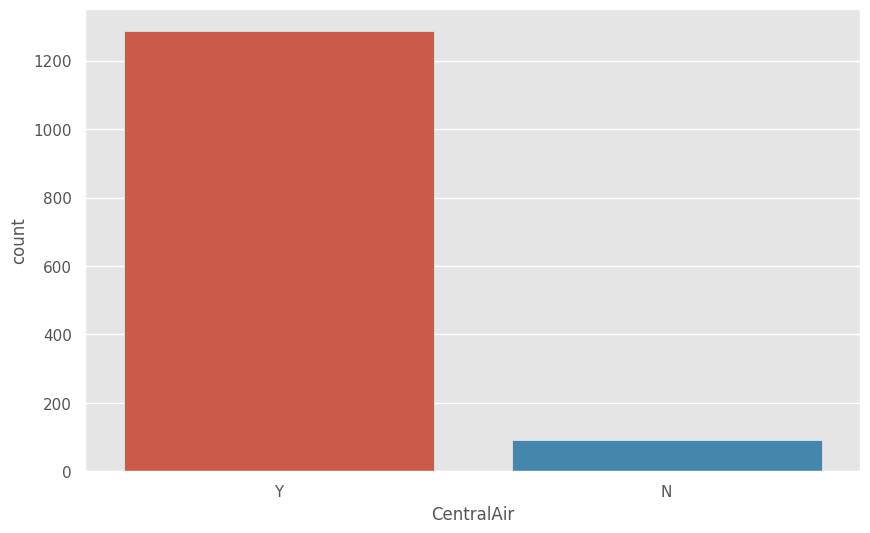

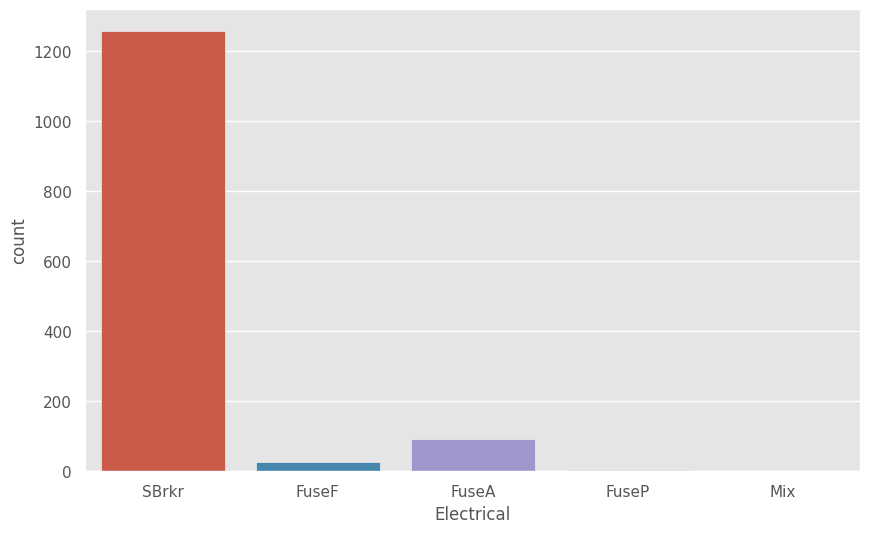

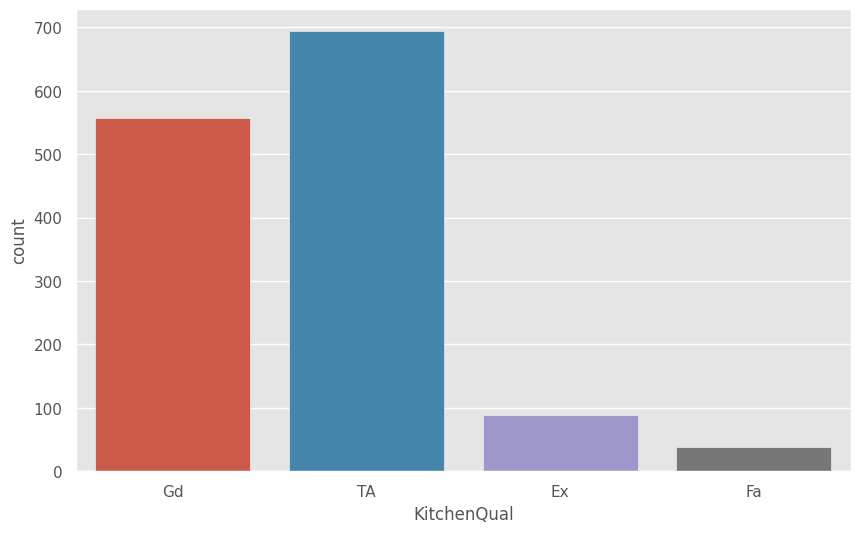

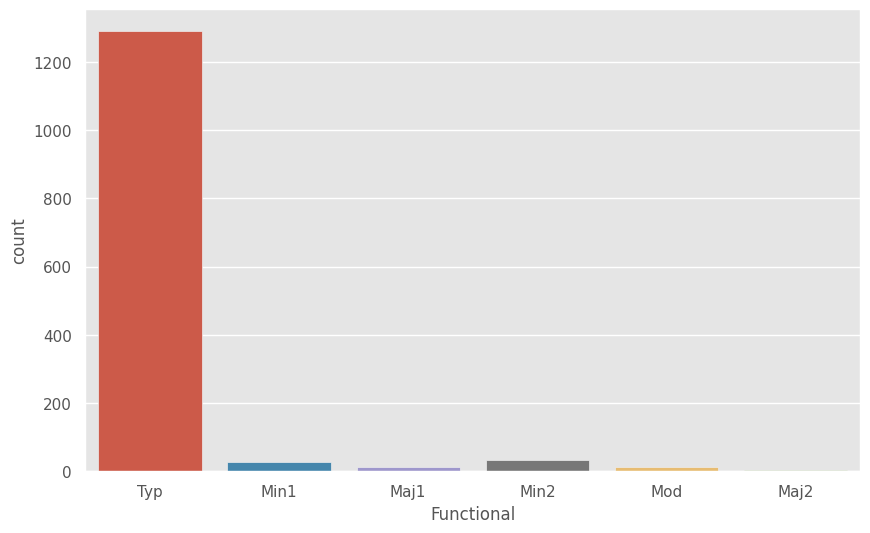

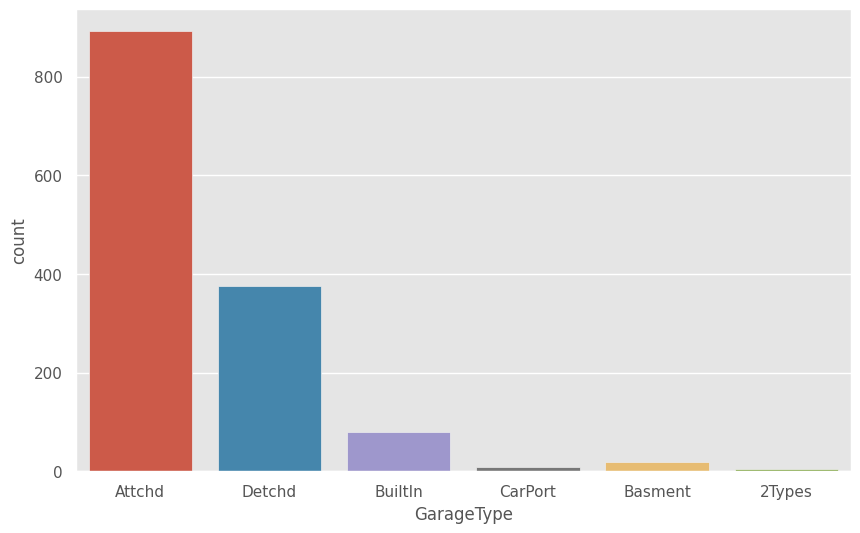

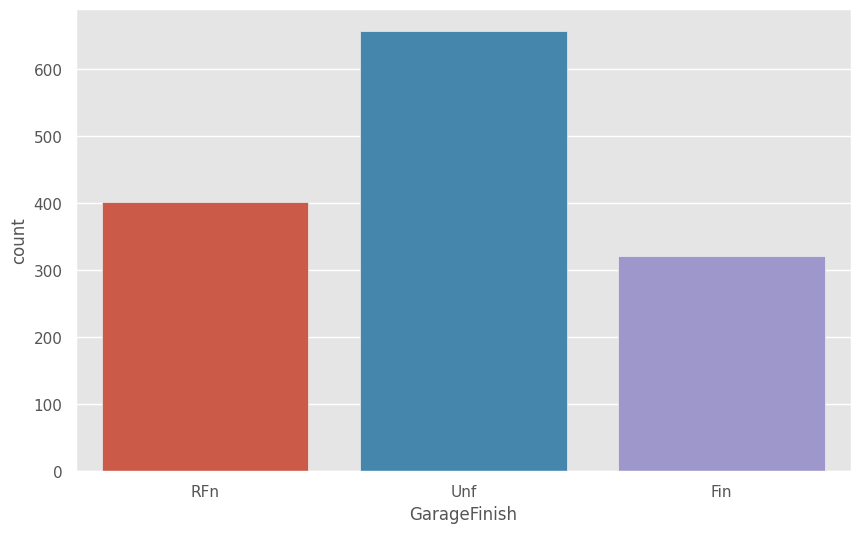

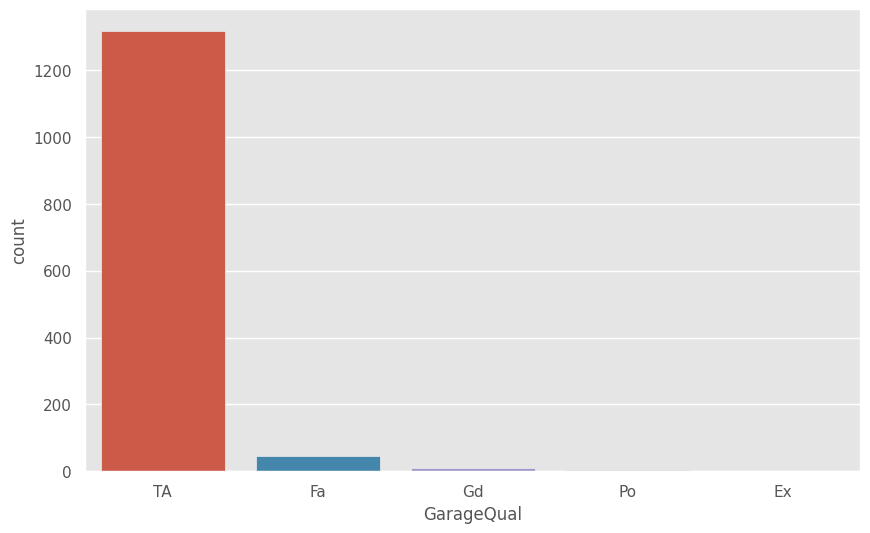

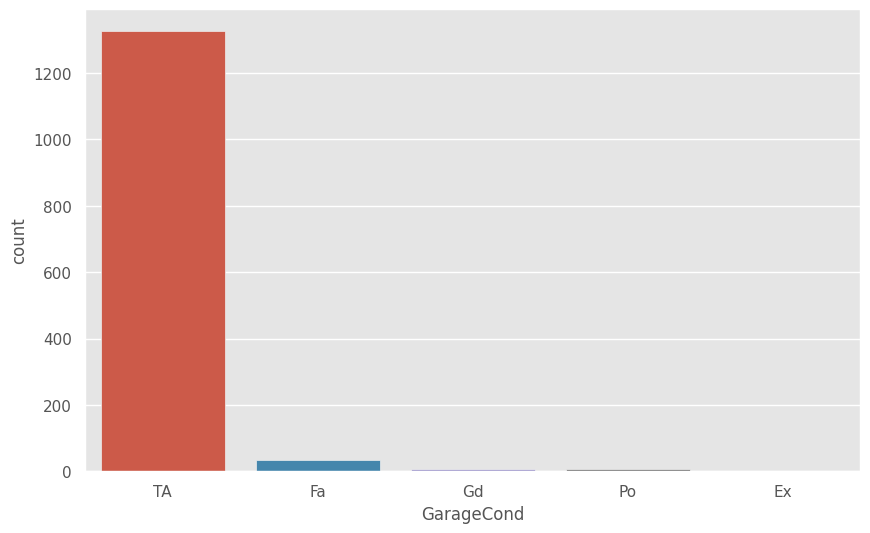

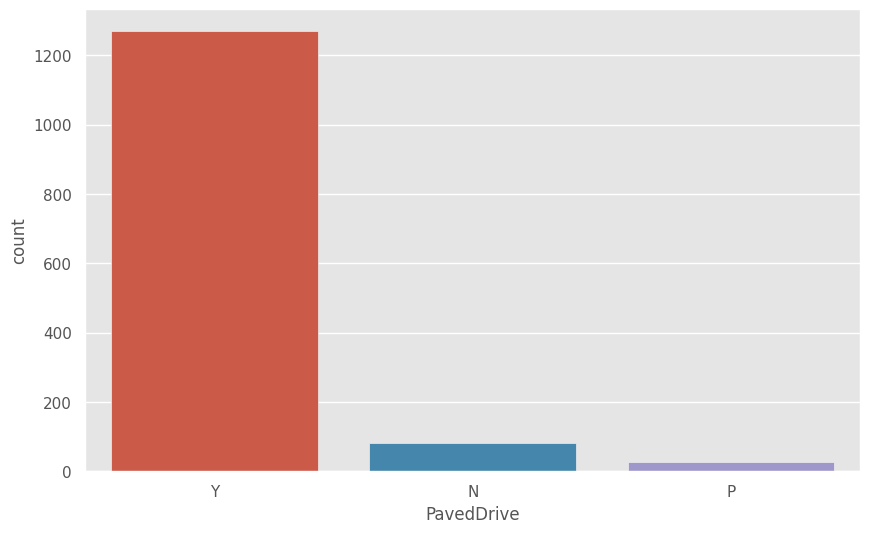

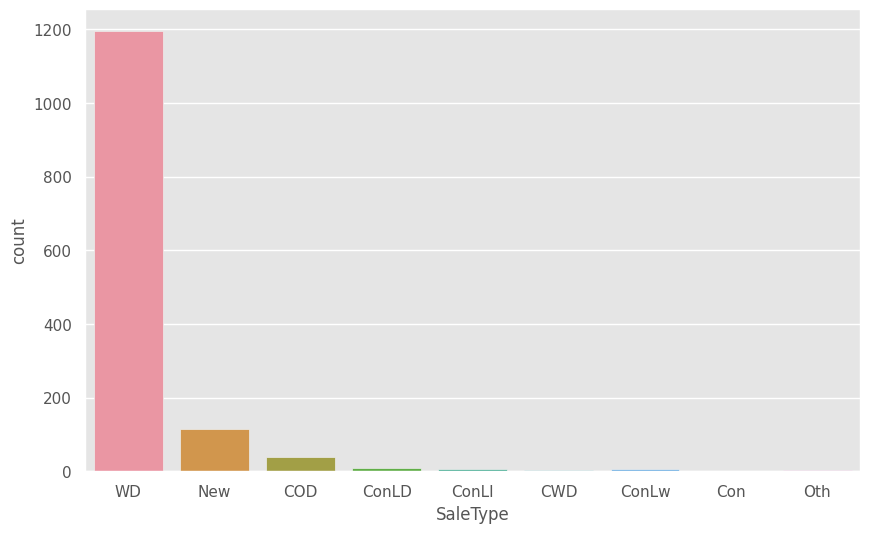

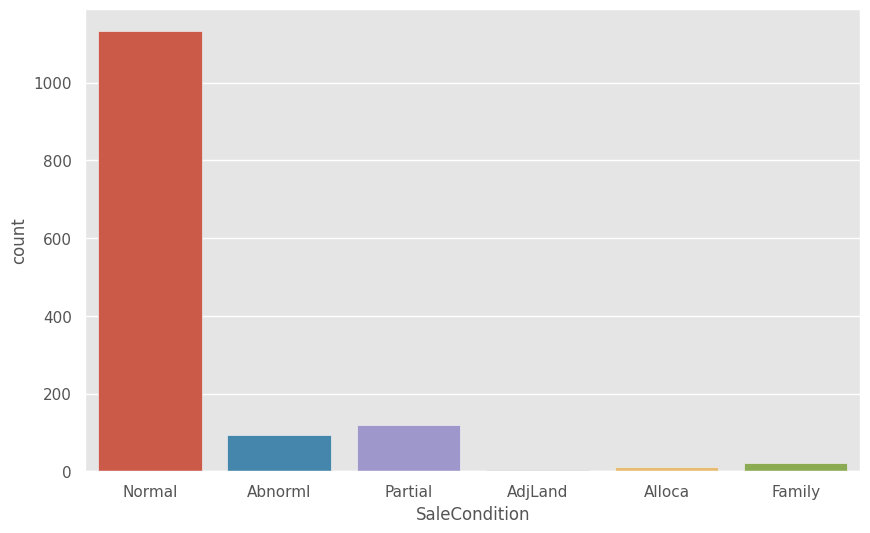

In [288]:
for col in cat_cols:
    sns.countplot(data=train,x=col)
    plt.show()

In [375]:
columns_to_drop=['Street','Utilities','Condition2','RoofMatl','Heating','Functional',
                 'GarageQual','GarageCond','LandContour','LandSlope','Neighborhood','Condition1','Condition2'
                ,'RoofMatl','ExterCond','BsmtCond','Electrical']
train.drop(columns=columns_to_drop,inplace=True)
test.drop(columns=columns_to_drop,inplace=True)

In [376]:
new_cat_cols=train.select_dtypes(object)
for col in new_cat_cols:
    print(f"{col}")
    print(f"Number of unique values: {train[col].nunique()}")
    print(train[col].unique())
    print(40*"-")

MSZoning
Number of unique values: 5
['RL' 'RM' 'C (all)' 'FV' 'RH']
----------------------------------------
LotShape
Number of unique values: 4
['Reg' 'IR1' 'IR2' 'IR3']
----------------------------------------
LotConfig
Number of unique values: 5
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
----------------------------------------
BldgType
Number of unique values: 5
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
----------------------------------------
HouseStyle
Number of unique values: 8
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
----------------------------------------
RoofStyle
Number of unique values: 5
['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat']
----------------------------------------
Exterior1st
Number of unique values: 15
['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'AsbShng' 'Stucco' 'Plywood' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
----------------------------------------
Exterior2nd
Number of unique values: 16
['Vi

In [291]:
#TA,Fa,Gd,Po,Ex - GarageQual, GarageCond, ExterCond, HeatingQC
#Gd,TA,Ex,Fa - ExterQual,BstmQual,BsmtCond,KitchenQual
#No,Gd,Mn,Av - BsmtExposure
#GLQ,ALQ,Unf,Rec,BLQ,LwQ - BsmtFinType1, BsmtFinType2
#Y,N,P - PavedDrive
#Y,N - CentralAir
#IR3,IR2,IR1,Reg - LotShape
#Unf, RFn, Fin - GarageFinish
#Low,HLS,Bnk,Lvl - LandContour
#Sev, Mod,Gtl - LandSlope

In [377]:
quality_map = {'Po': 0,'Fa': 1,'TA': 2,'Gd': 3,  'Ex': 4}
train['HeatingQC']=train['HeatingQC'].map(quality_map)
test['HeatingQC']=test['HeatingQC'].map(quality_map)

In [378]:
qual_map_2 = {'Fa': 1,'TA': 2,'Gd': 3,'Ex': 4}
train['ExterQual']=train['ExterQual'].map(qual_map_2)
test['ExterQual']=test['ExterQual'].map(qual_map_2)
train['BsmtQual']=train['BsmtQual'].map(qual_map_2)
test['BsmtQual']=test['BsmtQual'].map(qual_map_2)
train['KitchenQual']=train['KitchenQual'].map(qual_map_2)
test['KitchenQual']=test['KitchenQual'].map(qual_map_2)

In [379]:
bsmt_exposure_map = {'No': 0,  'Mn': 1,  'Av': 2, 'Gd': 3  }
train['BsmtExposure']=train['BsmtExposure'].map(bsmt_exposure_map)
test['BsmtExposure']=test['BsmtExposure'].map(bsmt_exposure_map)

In [380]:
bsmt_fin_type_map = {'Unf': 0,  'LwQ': 1,'Rec': 2,  'BLQ': 3,  'ALQ': 4, 'GLQ': 5}
train['BsmtFinType1']=train['BsmtFinType1'].map(bsmt_fin_type_map)
test['BsmtFinType1']=test['BsmtFinType1'].map(bsmt_fin_type_map)
train['BsmtFinType2']=train['BsmtFinType2'].map(bsmt_fin_type_map)
test['BsmtFinType2']=test['BsmtFinType2'].map(bsmt_fin_type_map)

In [381]:
paved_drive_map = {'N': 0,  'P': 1,'Y': 2}
train['PavedDrive']=train['PavedDrive'].map(paved_drive_map)
test['PavedDrive']=test['PavedDrive'].map(paved_drive_map)

In [382]:
central_air_map = {'N': 0,'Y': 1}
train['CentralAir']=train['CentralAir'].map(central_air_map)
test['CentralAir']=test['CentralAir'].map(central_air_map)
#CentralAir

In [383]:
lot_shape_map = {'IR3': 0,'IR2': 1,'IR1': 2,'Reg': 3}
train['LotShape']=train['LotShape'].map(lot_shape_map)
test['LotShape']=test['LotShape'].map(lot_shape_map)

In [384]:
garage_finish_map = {'Unf': 0, 'RFn': 1,  'Fin': 2}
train['GarageFinish']=train['GarageFinish'].map(garage_finish_map)
test['GarageFinish']=test['GarageFinish'].map(garage_finish_map)
#GarageFinish


In [385]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,RL,65.0,8450.0,3,Inside,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,VinylSd,VinylSd,196.0,3,PConc,3,0,5,706.0,0,0.0,150.0,856.0,4,1,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,3,8.0,0.0,Attchd,2003.0,1,2.0,548.0,2,0.0,61.0,0.0,0.0,0.0,2.0,2008.0,WD,Normal,208500
1,20.0,RL,80.0,9600.0,3,FR2,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,MetalSd,MetalSd,0.0,2,CBlock,3,3,4,978.0,0,0.0,284.0,1262.0,4,1,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,2,6.0,1.0,Attchd,1976.0,1,2.0,460.0,2,298.0,0.0,0.0,0.0,0.0,5.0,2007.0,WD,Normal,181500
2,60.0,RL,68.0,11250.0,2,Inside,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,VinylSd,VinylSd,162.0,3,PConc,3,1,5,486.0,0,0.0,434.0,920.0,4,1,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,3,6.0,1.0,Attchd,2001.0,1,2.0,608.0,2,0.0,42.0,0.0,0.0,0.0,9.0,2008.0,WD,Normal,223500
3,70.0,RL,60.0,9550.0,2,Corner,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,Wd Sdng,Wd Shng,0.0,2,BrkTil,2,0,4,216.0,0,0.0,540.0,756.0,3,1,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,3,7.0,1.0,Detchd,1998.0,0,3.0,642.0,2,0.0,35.0,272.0,0.0,0.0,2.0,2006.0,WD,Abnorml,140000
4,60.0,RL,84.0,14260.0,2,FR2,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,VinylSd,VinylSd,350.0,3,PConc,3,2,5,655.0,0,0.0,490.0,1145.0,4,1,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,3,9.0,1.0,Attchd,2000.0,1,3.0,836.0,2,192.0,84.0,0.0,0.0,0.0,12.0,2008.0,WD,Normal,250000


In [386]:
cat_cols=train.select_dtypes(object)
for col in cat_cols:
    print(f"{col}: {train[col].nunique()}")

MSZoning: 5
LotConfig: 5
BldgType: 5
HouseStyle: 8
RoofStyle: 5
Exterior1st: 15
Exterior2nd: 16
Foundation: 6
GarageType: 6
SaleType: 9
SaleCondition: 6


In [387]:
le=LabelEncoder()
train['Exterior1st']=le.fit_transform(train['Exterior1st'])
test['Exterior1st']=le.transform(test['Exterior1st'])
le=LabelEncoder()
train['Exterior2nd']=le.fit_transform(train['Exterior2nd'])
test['Exterior2nd']=le.transform(test['Exterior2nd'])

In [388]:
train.dropna(inplace=True)

In [389]:
categorical_cols = [
    'MSZoning', 'LotConfig', 'BldgType', 'HouseStyle',
    'RoofStyle', 'Foundation', 'GarageType', 'SaleType', 'SaleCondition'
]

encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

encoded_train = encoder.fit_transform(train[categorical_cols])
encoded_test = encoder.transform(test[categorical_cols])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_cols), index=train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols), index=test.index)

train = pd.concat([train.drop(columns=categorical_cols), encoded_train_df], axis=1)
test = pd.concat([test.drop(columns=categorical_cols), encoded_test_df], axis=1)


In [309]:
train.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60.0,65.0,8450.0,3,3,2,5,7.0,5.0,2003.0,2003.0,12,13,196.0,3,2,3,2.0,0,5,706.0,0,0.0,150.0,856.0,4,1,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,3,8.0,0.0,2003.0,1,2.0,548.0,2,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,20.0,80.0,9600.0,3,3,2,24,6.0,8.0,1976.0,1976.0,8,8,0.0,2,2,3,2.0,3,4,978.0,0,0.0,284.0,1262.0,4,1,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,2,6.0,1.0,1976.0,1,2.0,460.0,2,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,60.0,68.0,11250.0,2,3,2,5,7.0,5.0,2001.0,2002.0,12,13,162.0,3,2,3,2.0,1,5,486.0,0,0.0,434.0,920.0,4,1,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,3,6.0,1.0,2001.0,1,2.0,608.0,2,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,70.0,60.0,9550.0,2,3,2,6,7.0,5.0,1915.0,1970.0,13,15,0.0,2,2,2,3.0,0,4,216.0,0,0.0,540.0,756.0,3,1,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,3,7.0,1.0,1998.0,0,3.0,642.0,2,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60.0,84.0,14260.0,2,3,2,15,8.0,5.0,2000.0,2000.0,12,13,350.0,3,2,3,2.0,2,5,655.0,0,0.0,490.0,1145.0,4,1,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,3,9.0,1.0,2000.0,1,3.0,836.0,2,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


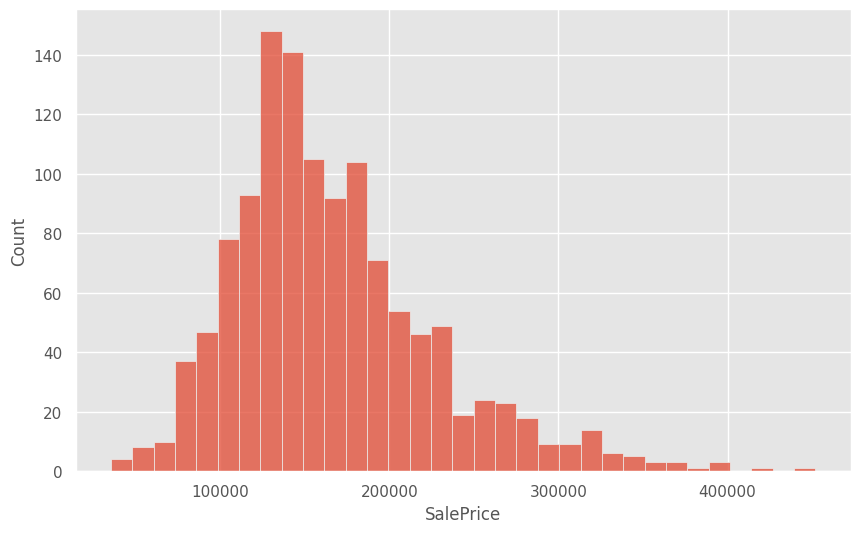

In [390]:
sns.histplot(data=train,x='SalePrice')
plt.show()

<Axes: xlabel='SalePrice'>

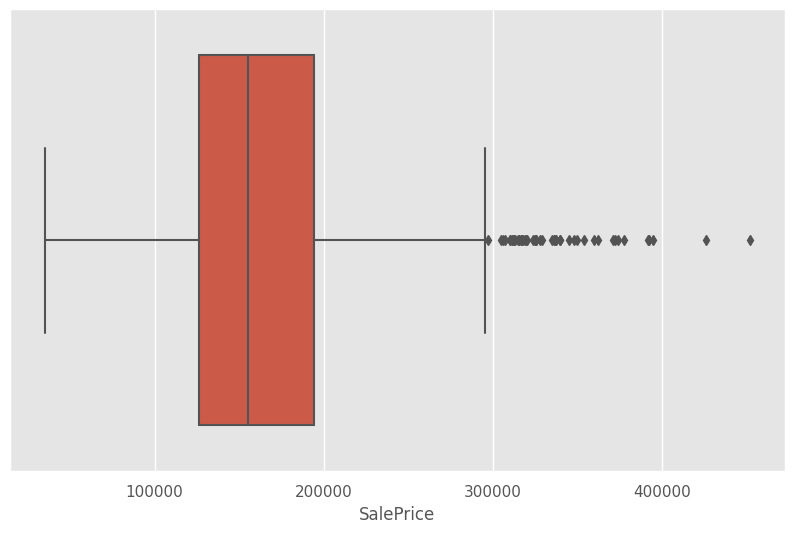

In [391]:
sns.boxplot(data=train,x='SalePrice')

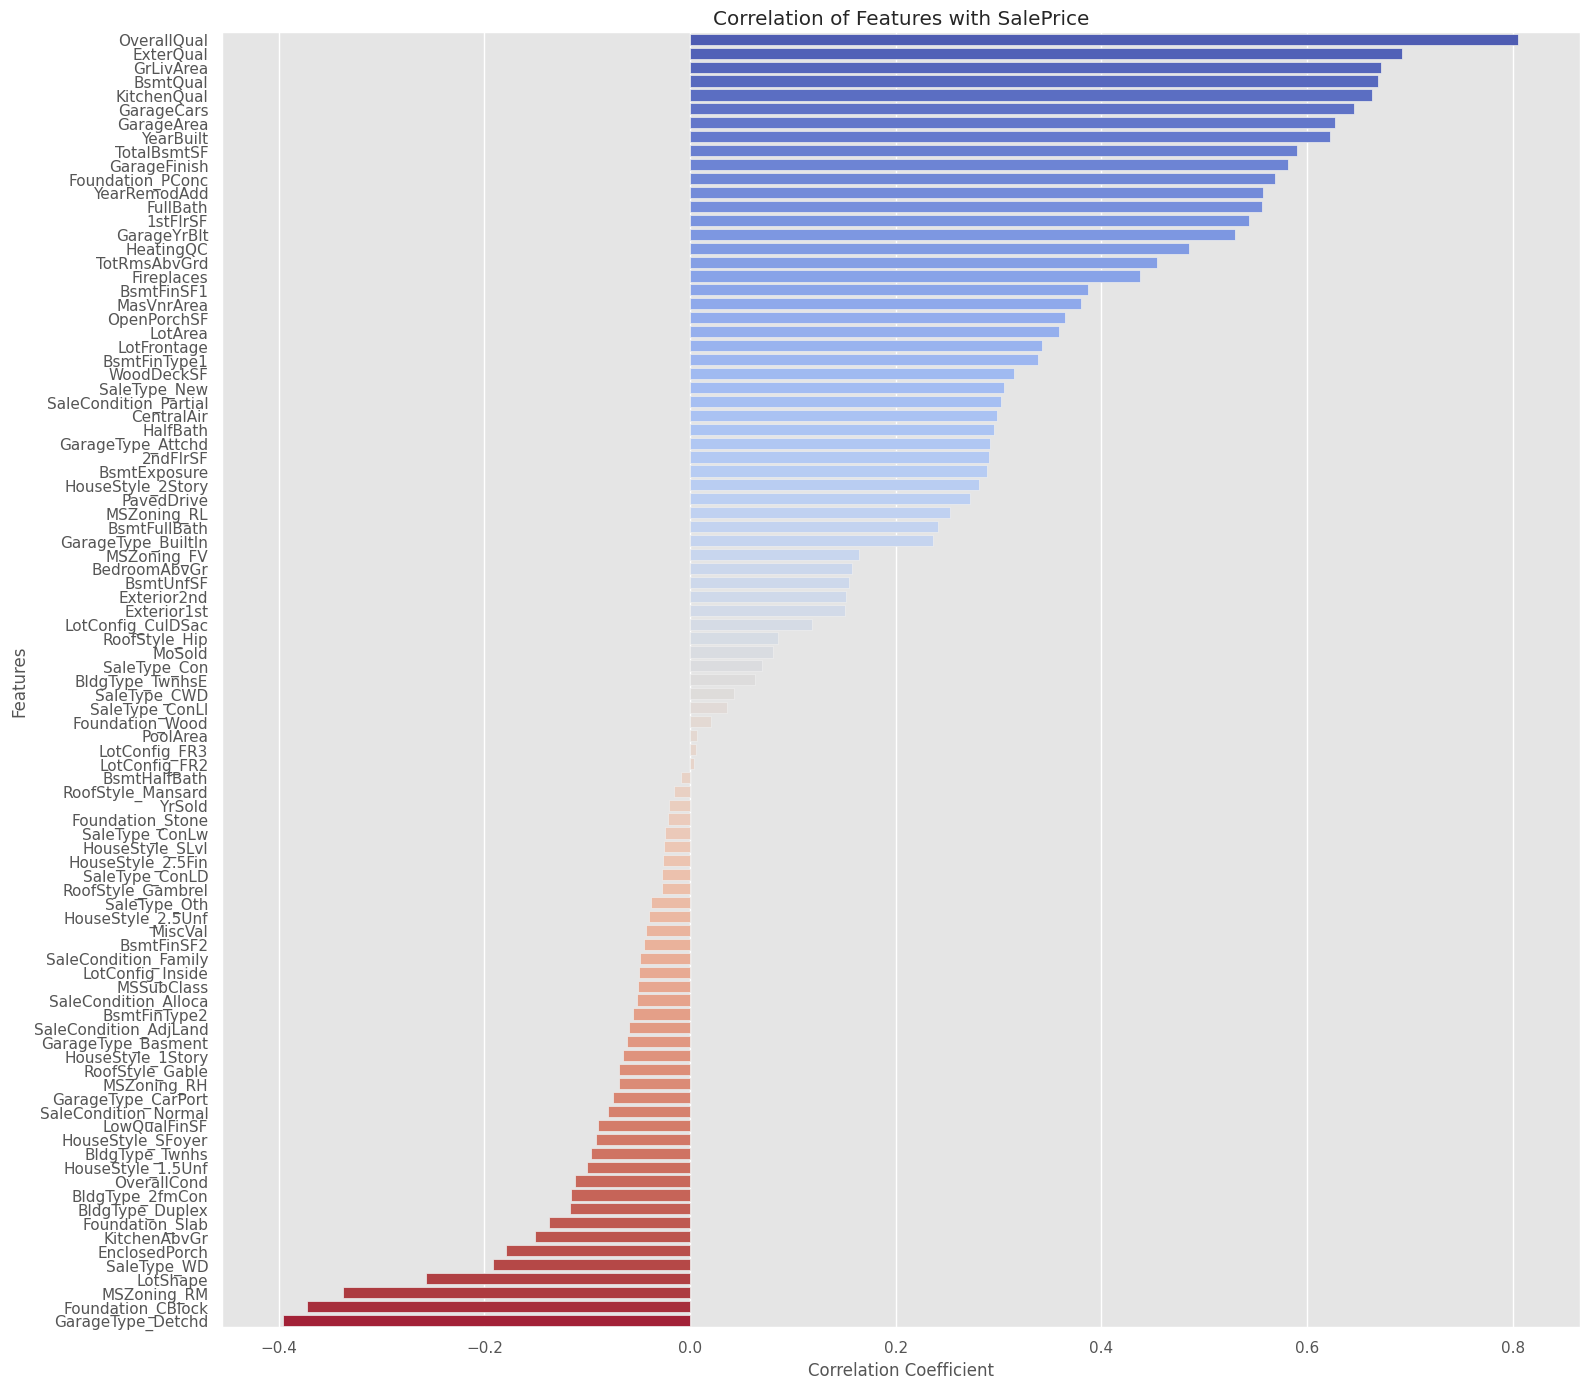

In [393]:
correlation = train.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)
correlation = correlation.drop('SalePrice')
plt.figure(figsize=(16, 14))
sns.barplot(x=correlation.values, y=correlation.index, palette='coolwarm')
plt.title('Correlation of Features with SalePrice')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [397]:
correlation = train.corr(numeric_only=True)['SalePrice']
weak_corr = correlation[(correlation > -0.1) & (correlation < 0.1)]
print(weak_corr.sort_values())

BldgType_Twnhs          -0.096386
HouseStyle_SFoyer       -0.091642
LowQualFinSF            -0.089408
SaleCondition_Normal    -0.079503
GarageType_CarPort      -0.074492
MSZoning_RH             -0.069021
RoofStyle_Gable         -0.068835
HouseStyle_1Story       -0.065710
GarageType_Basment      -0.060971
SaleCondition_AdjLand   -0.059206
BsmtFinType2            -0.055596
SaleCondition_Alloca    -0.051331
MSSubClass              -0.051080
LotConfig_Inside        -0.049704
SaleCondition_Family    -0.048661
BsmtFinSF2              -0.044803
MiscVal                 -0.042804
HouseStyle_2.5Unf       -0.040342
SaleType_Oth            -0.038285
RoofStyle_Gambrel       -0.027512
SaleType_ConLD          -0.027354
HouseStyle_2.5Fin       -0.026616
HouseStyle_SLvl         -0.025657
SaleType_ConLw          -0.024053
Foundation_Stone        -0.021650
YrSold                  -0.020642
RoofStyle_Mansard       -0.016062
BsmtHalfBath            -0.008986
LotConfig_FR2            0.003556
LotConfig_FR3 

In [398]:
to_drop=['LowQualFinSF','BsmtFinSF2','MiscVal','BsmtHalfBath','YrSold','MoSold','MSSubClass']
train.drop(columns=to_drop,inplace=True)
test.drop(columns=to_drop,inplace=True)

In [399]:
train.head()

,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolArea,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450.0,3,7.0,5.0,2003.0,2003.0,12,13,196.0,3,3,0,5,706.0,0,150.0,856.0,4,1,856.0,854.0,1710.0,1.0,2.0,1.0,3.0,1.0,3,8.0,0.0,2003.0,1,2.0,548.0,2,0.0,61.0,0.0,0.0,208500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,80.0,9600.0,3,6.0,8.0,1976.0,1976.0,8,8,0.0,2,3,3,4,978.0,0,284.0,1262.0,4,1,1262.0,0.0,1262.0,0.0,2.0,0.0,3.0,1.0,2,6.0,1.0,1976.0,1,2.0,460.0,2,298.0,0.0,0.0,0.0,181500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,68.0,11250.0,2,7.0,5.0,2001.0,2002.0,12,13,162.0,3,3,1,5,486.0,0,434.0,920.0,4,1,920.0,866.0,1786.0,1.0,2.0,1.0,3.0,1.0,3,6.0,1.0,2001.0,1,2.0,608.0,2,0.0,42.0,0.0,0.0,223500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,60.0,9550.0,2,7.0,5.0,1915.0,1970.0,13,15,0.0,2,2,0,4,216.0,0,540.0,756.0,3,1,961.0,756.0,1717.0,1.0,1.0,0.0,3.0,1.0,3,7.0,1.0,1998.0,0,3.0,642.0,2,0.0,35.0,272.0,0.0,140000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,84.0,14260.0,2,8.0,5.0,2000.0,2000.0,12,13,350.0,3,3,2,5,655.0,0,490.0,1145.0,4,1,1145.0,1053.0,2198.0,1.0,2.0,1.0,4.0,1.0,3,9.0,1.0,2000.0,1,3.0,836.0,2,192.0,84.0,0.0,0.0,250000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [404]:
train.iloc[:,0:40].head()

,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolArea
0,65.0,8450.0,3,7.0,5.0,2003.0,2003.0,12,13,196.0,3,3,0,5,706.0,0,150.0,856.0,4,1,856.0,854.0,1710.0,1.0,2.0,1.0,3.0,1.0,3,8.0,0.0,2003.0,1,2.0,548.0,2,0.0,61.0,0.0,0.0
1,80.0,9600.0,3,6.0,8.0,1976.0,1976.0,8,8,0.0,2,3,3,4,978.0,0,284.0,1262.0,4,1,1262.0,0.0,1262.0,0.0,2.0,0.0,3.0,1.0,2,6.0,1.0,1976.0,1,2.0,460.0,2,298.0,0.0,0.0,0.0
2,68.0,11250.0,2,7.0,5.0,2001.0,2002.0,12,13,162.0,3,3,1,5,486.0,0,434.0,920.0,4,1,920.0,866.0,1786.0,1.0,2.0,1.0,3.0,1.0,3,6.0,1.0,2001.0,1,2.0,608.0,2,0.0,42.0,0.0,0.0
3,60.0,9550.0,2,7.0,5.0,1915.0,1970.0,13,15,0.0,2,2,0,4,216.0,0,540.0,756.0,3,1,961.0,756.0,1717.0,1.0,1.0,0.0,3.0,1.0,3,7.0,1.0,1998.0,0,3.0,642.0,2,0.0,35.0,272.0,0.0
4,84.0,14260.0,2,8.0,5.0,2000.0,2000.0,12,13,350.0,3,3,2,5,655.0,0,490.0,1145.0,4,1,1145.0,1053.0,2198.0,1.0,2.0,1.0,4.0,1.0,3,9.0,1.0,2000.0,1,3.0,836.0,2,192.0,84.0,0.0,0.0


In [405]:
X=train.drop('SalePrice',axis=1)
y=train['SalePrice']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [406]:
X_train.iloc[:,0:40].head()

,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolArea
746,69.0,7000.0,2,5.0,8.0,1978.0,2005.0,12,13,90.0,3,2,0,4,646.0,0,218.0,864.0,4,1,864.0,0.0,864.0,1.0,1.0,0.0,3.0,1.0,2,6.0,0.0,1978.0,0,1.0,336.0,2,0.0,0.0,0.0,0.0
846,74.0,10206.0,3,3.0,3.0,1952.0,1952.0,2,2,0.0,2,2,0,0,0.0,0,0.0,0.0,1,0,944.0,0.0,944.0,0.0,1.0,0.0,2.0,1.0,1,4.0,0.0,1956.0,0,2.0,528.0,2,0.0,0.0,0.0,0.0
904,60.0,9600.0,3,5.0,7.0,1949.0,2003.0,8,8,0.0,2,2,0,4,220.0,0,625.0,845.0,2,1,893.0,0.0,893.0,0.0,1.0,0.0,2.0,1.0,3,4.0,0.0,1985.0,0,2.0,576.0,2,0.0,0.0,0.0,0.0
549,85.0,10452.0,2,6.0,5.0,1953.0,1953.0,13,14,216.0,2,2,1,2,500.0,0,594.0,1094.0,4,1,1094.0,0.0,1094.0,0.0,1.0,0.0,3.0,1.0,2,5.0,2.0,1953.0,1,2.0,495.0,2,0.0,0.0,0.0,0.0
907,50.0,7585.0,3,5.0,3.0,1948.0,1950.0,8,8,0.0,2,1,1,0,0.0,0,810.0,810.0,1,1,1002.0,454.0,1456.0,1.0,1.0,0.0,4.0,1.0,2,7.0,1.0,1954.0,0,1.0,280.0,1,0.0,0.0,0.0,0.0


In [407]:
scaler = StandardScaler()

X_train.iloc[:,0:40] = scaler.fit_transform(X_train.iloc[:,0:40])
X_test.iloc[:,0:40]= scaler.transform(X_test.iloc[:,0:40])

### 1. Linear Regression

Intercept: 126272.51372723894
MSE 444171242.14629453
R2:  0.8816462042124497
MAE:  15573.505279576213


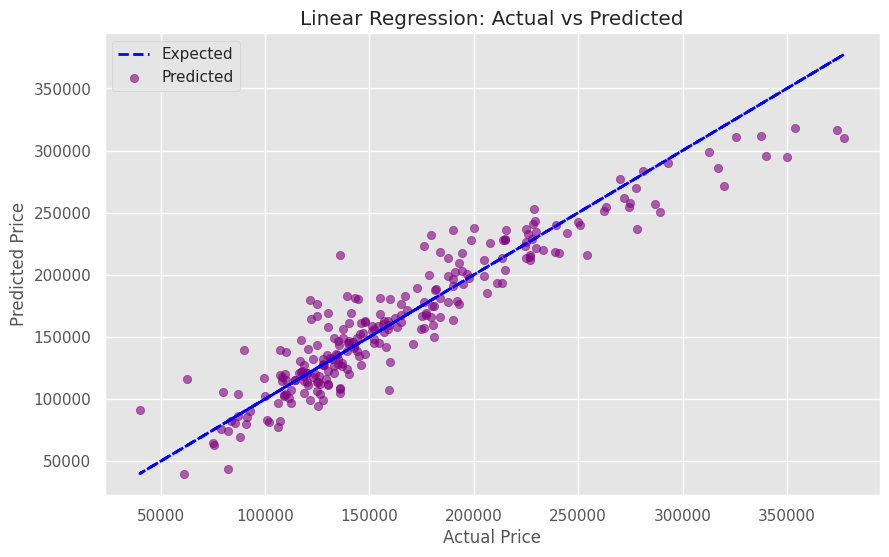

In [408]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('Intercept:',lr.intercept_)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('MSE', mse)
print('R2: ',r2)
print('MAE: ',mae)

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred, color='purple', alpha=0.6, label='Predicted')

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

### 2. Ridge

Ridge Intercept: 142962.51615955966
Ridge MSE: 431475924.1826533
Ridge R2: 0.8850289965392701
Ridge MAE: 15364.118759359211


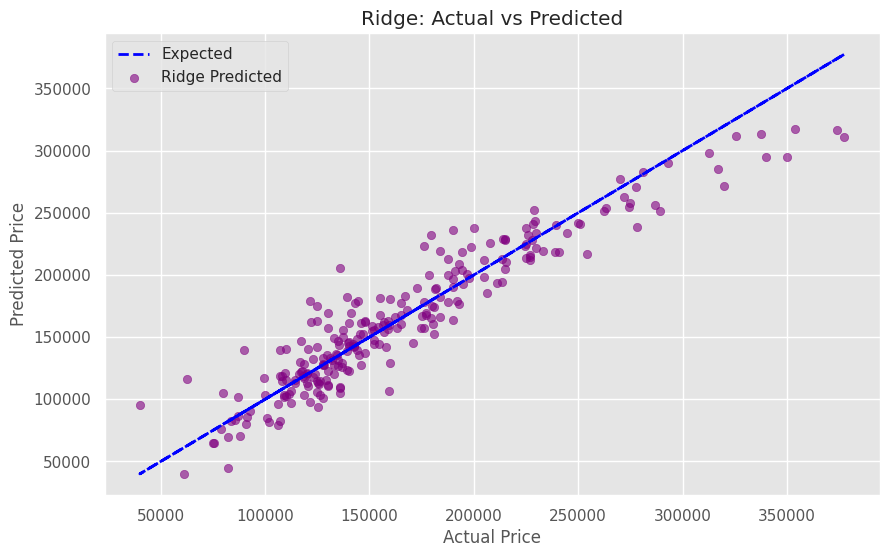

In [409]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print('Ridge Intercept:', ridge.intercept_)

r2 = r2_score(y_test, y_pred_ridge)
mae = mean_absolute_error(y_test, y_pred_ridge)
mse = mean_squared_error(y_test, y_pred_ridge)
print('Ridge MSE:', mse)
print('Ridge R2:', r2)
print('Ridge MAE:', mae)

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_ridge, color='purple', alpha=0.6, label='Ridge Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Ridge: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

### 3. Lasso

Lasso Intercept: 126705.4517436031
Lasso MSE: 444089514.8510931
Lasso R2: 0.8816679812540243
Lasso MAE: 15572.362383024754


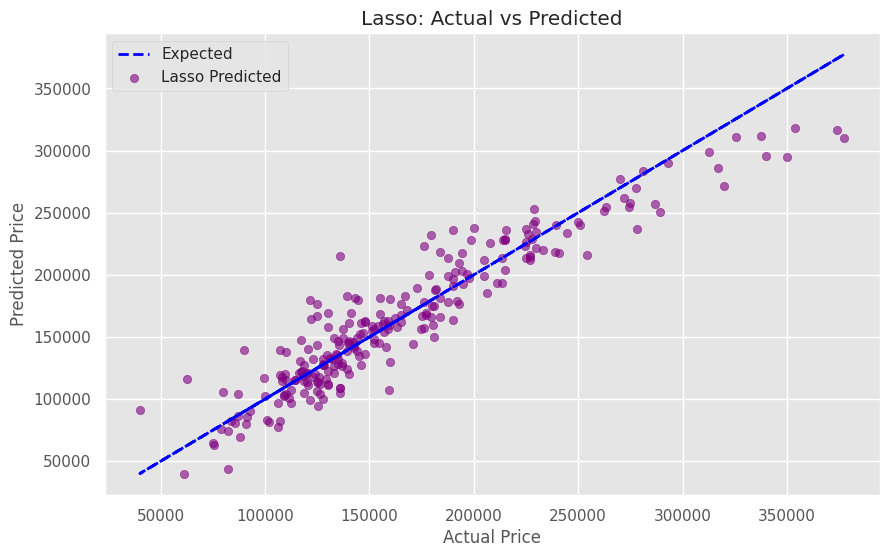

In [410]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

print('Lasso Intercept:', lasso.intercept_)

r2 = r2_score(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)
mse = mean_squared_error(y_test, y_pred_lasso)
print('Lasso MSE:', mse)
print('Lasso R2:', r2)
print('Lasso MAE:', mae)

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_lasso, color='purple', alpha=0.6, label='Lasso Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Lasso: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

### 4. Random Forest Regressor

In [411]:
rf = RandomForestRegressor(random_state=2, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(rf,param_grid,n_iter=100,               
    scoring='neg_mean_squared_error',cv=5,random_state=42,n_jobs=-1,verbose=2
)

random_search_rf.fit(X_train, y_train)

print("Best Params:", random_search_rf.best_params_)
print("Best R² score:", random_search_rf.best_score_)
print("Best RMSE:", (-random_search_rf.best_score_)**0.5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=3

Test R²: 0.902
Test MAE: 13,692
Test MSE: 369276972.457
RMSE: 19216.58


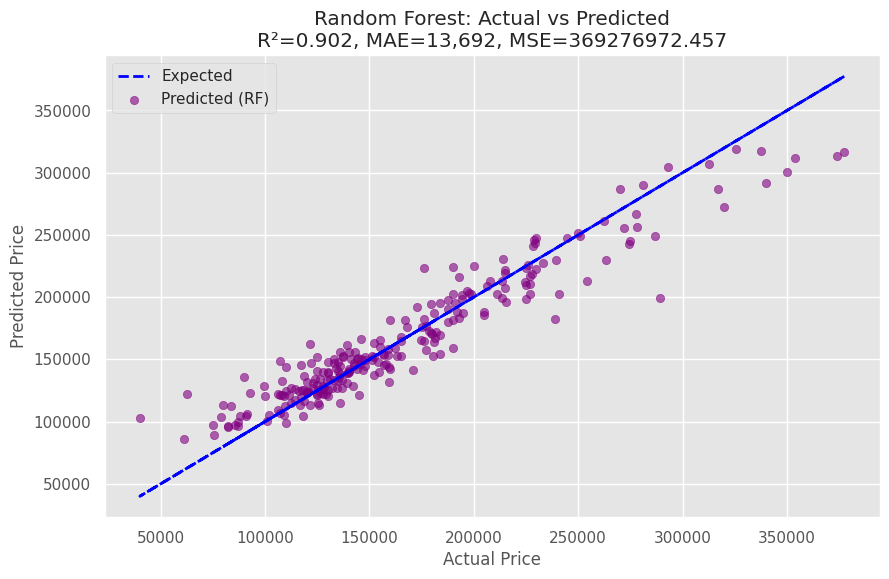

In [412]:
best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_rf, color='purple', alpha=0.6, label='Predicted (RF)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Random Forest: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

### 5. Gradient Boost Regressor

In [413]:
gbr= GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 300, 500],           
    'learning_rate': [0.01, 0.1, 0.2],             
    'max_depth': [5, 10, 15],                         
    'min_samples_split': [2, 5, 10],                    
    'min_samples_leaf': [1, 2, 4],                       
    'max_features': ['sqrt', 'log2'],                         
}

random_search_gbr = RandomizedSearchCV(gbr,param_grid,n_iter=100,               
    scoring='neg_mean_squared_error',cv=5,random_state=42,n_jobs=-1,verbose=2
)

random_search_gbr.fit(X_train, y_train)

print("Best Params:", random_search_gbr.best_params_)
print("Best R² score:", random_search_gbr.best_score_)
print("Best RMSE:", (-random_search_gbr.best_score_)**0.5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato

Test R²: 0.913
Test MAE: 13,348
Test MSE: 327863285.601
RMSE: 18107.00


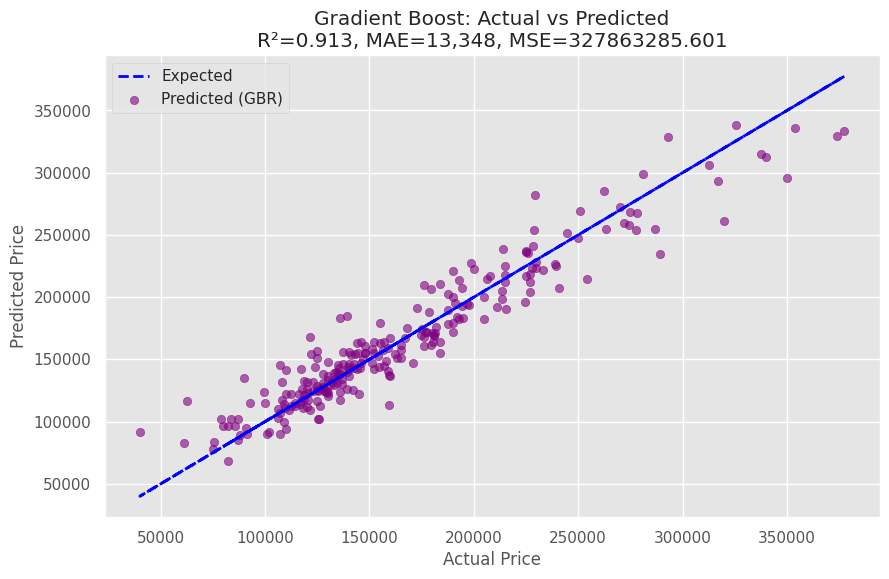

In [414]:
best_gbr = random_search_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_test)

r2 = r2_score(y_test, y_pred_gbr)
mae = mean_absolute_error(y_test, y_pred_gbr)
mse = mean_squared_error(y_test, y_pred_gbr)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_gbr, color='purple', alpha=0.6, label='Predicted (GBR)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Gradient Boost: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

### 6. XGB

In [415]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
    'min_child_weight': [1, 3, 5],
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search_xgb = RandomizedSearchCV(xgb,param_grid,n_iter=100,scoring='neg_mean_squared_error',
    cv=5,verbose=1,n_jobs=-1)

random_search_xgb.fit(X_train, y_train)

print("Best Params:", random_search_xgb.best_params_)
print("Best R² score:", random_search_xgb.best_score_)
print("Best RMSE:", (-random_search_xgb.best_score_)**0.5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Params: {'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5}
Best R² score: -344127533.47386056
Best RMSE: 18550.67474443613


Test R²: 0.910
Test MAE: 13,465
Test MSE: 336339303.936
RMSE: 18339.56


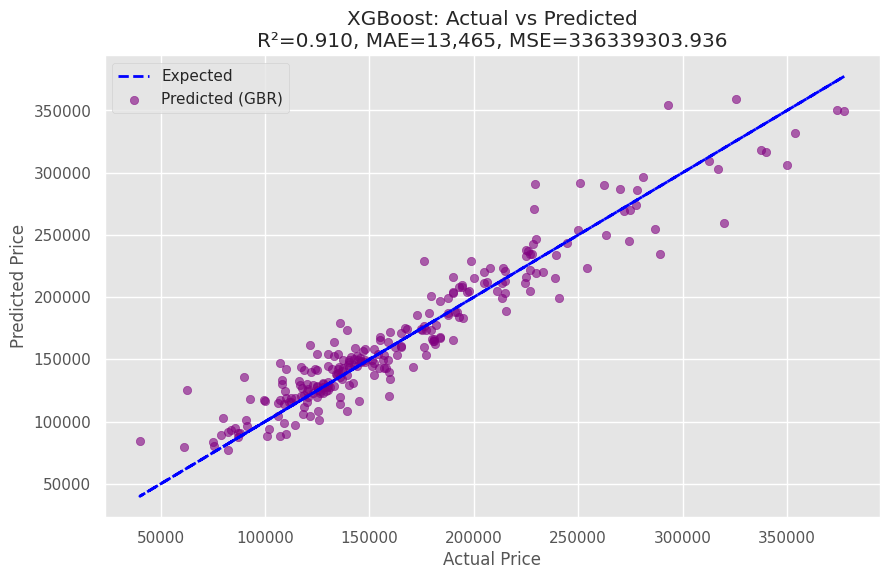

In [416]:
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_xgb, color='purple', alpha=0.6, label='Predicted (GBR)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'XGBoost: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

## Results

In [417]:
fitted_models = [
    ("Linear Regression", lr),
    ("Ridge Regression", ridge),
    ("Lasso Regression", lasso),
    ("Random Forest Regressor", best_rf),
    ("Gradient Boosting Regressor", best_gbr),
    ("XGBoost Regressor", best_xgb)
    
]

results = []

for name, model in fitted_models:
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mse ** 0.5

    results.append({
        "Model": name,
        "Train R² Score": train_r2,
        "Test R² Score": test_r2,
        "Mean Squared Error": mse,
        "Mean Absolute Error": mae,
        "Root Mean Squared Error": rmse
    })

results_df = pd.DataFrame(results)
results_df

,Model,Train R² Score,Test R² Score,Mean Squared Error,Mean Absolute Error,Root Mean Squared Error
0,Linear Regression,0.904727,0.881646,4.441712e+08,15573.505280,21075.370510
1,Ridge Regression,0.904177,0.885029,4.314759e+08,15364.118759,20771.998560
2,Lasso Regression,0.904727,0.881668,4.440895e+08,15572.362383,21073.431492
3,Random Forest Regressor,0.984321,0.901603,3.692770e+08,13692.375959,19216.580665
4,Gradient Boosting Regressor,0.997432,0.912638,3.278633e+08,13348.139900,18106.995488
5,XGBoost Regressor,0.976078,0.910379,3.363393e+08,13464.736280,18339.555718


In [418]:
test.isnull().sum().sort_values(ascending=False)

Id                       0
HouseStyle_2.5Fin        0
RoofStyle_Mansard        0
RoofStyle_Hip            0
RoofStyle_Gambrel        0
                        ..
BedroomAbvGr             0
HalfBath                 0
FullBath                 0
BsmtFullBath             0
SaleCondition_Partial    0
Length: 87, dtype: int64

In [419]:
test_df=test.drop('Id',axis=1)

In [420]:
test_preds = best_gbr.predict(test_df)
test_preds

array([365982.73355631, 378176.39191511, 406333.34621908, ...,
       376087.51008181, 381688.99717673, 410381.35442984])

In [421]:
submission = pd.DataFrame({
    'Id': test['Id'], 
    'SalePrice': test_preds
})

In [422]:
submission.head()

,Id,SalePrice
0,1461,365982.733556
1,1462,378176.391915
2,1463,406333.346219
3,1464,405278.356814
4,1465,390963.372930


In [423]:
submission.shape

(1459, 2)

In [424]:
submission.to_csv('submission.csv',index=False)



[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END learning_ra